<a href="https://colab.research.google.com/github/shubham2279/Routing/blob/main/OfflineTraining_ContinuousChangingPreferences_3_Oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from bisect import bisect
plt.rcParams['figure.dpi'] = 90
plt.rcParams.update({'font.size': 12})

In [2]:
#define the shape of the environment (i.e., its states)
environment_rows = 10
environment_columns = 10
initial_node_energy = 25.0  # the initial energy of each node in the network
number_of_episodes = 1100
training_episodes = 1000
duration_testing_subepisode = 1000
transmission_energy_cost = 0.007  # the amount of energy(mJ) consumed by a node forward a packet to 1 hop distance, and receive acknowledgement from that node
active_mode_energy_cost = 0.0005  # the amount of energy(mj) cosumed by a node for being in active mode
# sleep_mode_energy_cost = 0.00025  # the amount of energy(mj) cosumed by a node for being in sleep mode

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a)
#The array contains 10 rows and 10 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions).
#The value of each (state, action) pair is initialized to 0.


#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']
episode_preferences =  []
for episode in range(number_of_episodes):
  episode_preferences.append(random.uniform(0, 1))


class Q_Tables():
  def __init__(self, learning_rate, initial_preference_set):
    self.q_values_pt0 = np.zeros((environment_rows, environment_columns, 4))
    # q_values_pt01 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_pt1 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_pt2 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_pt3 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_pt4 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_pt5 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_pt6 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_pt7 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_pt8 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_pt9 = np.zeros((environment_rows, environment_columns, 4))
    self.q_values_1 = np.zeros((environment_rows, environment_columns, 4))
    self.q_curr = np.zeros((environment_rows, environment_columns, 4))
    self.learning_rate = learning_rate
    self.initial_preference_set = initial_preference_set

    self.q_dict = {
      0: self.q_values_pt0,
      0.1: self.q_values_pt1,
      0.2: self.q_values_pt2,
      0.3: self.q_values_pt3,
      0.4: self.q_values_pt4,
      0.5: self.q_values_pt5,
      0.6: self.q_values_pt6,
      0.7: self.q_values_pt7,
      0.8: self.q_values_pt8,
      0.9: self.q_values_pt9,
      1.0: self.q_values_1,
    }

  # def get_Q_table(self, preference):
  #   if preference in self.initial_preference_set:
  #     return self.q_dict[preference]
  #   else:
  #     r_preference = bisect(self.initial_preference_set, preference)
  #     l_preference = r_preference-1
  #     d_l = preference-l_preference
  #     d_r = r_preference-preference
  #     Q_l = self.q_dict[l_preference]
  #     Q_r = self.q_dict[r_preference]
  #     Q_curr =  Q_l*(d_r/(d_l+d_r)) + Q_r*(d_l/(d_l+d_r)) #Linear interpolation of Q-tables
  #     self.q_curr = Q_curr
  #     self.q_dict[preference] = Q_curr
  #     return self.q_curr

  # def get_Q_dict(self):
  #   return self.q_dict
  def verify_Q_exists(self, preference):
    # print("#################    preference = ", preference, "    ##########")
    if preference in self.q_dict:
      # print("#################    preference = ", preference, "    ##########")
      return True
    else:
      r_preference = bisect(self.initial_preference_set, preference)
      l_preference = r_preference-1
      # l_preference = self.initial_preference_set[l_preference]
      l_preference = self.initial_preference_set[l_preference]
      r_preference = self.initial_preference_set[r_preference]
      print("#################    preference = ", preference, "    ##########")
      print("^^^^^^^^^^^^^^^^^^    l_preference = ", l_preference, "    ^^^^^^^^^^^^^^^^^^")
      print("!!!!!!!!!!!!!!!!!    r_preference = ", r_preference, "   !!!!!!!!!!!!!!!!!")
      d_l = preference-l_preference
      d_r = r_preference-preference
      Q_l = self.q_dict[l_preference]
      Q_r = self.q_dict[r_preference]
      Q_curr =  Q_l*(d_r/(d_l+d_r)) + Q_r*(d_l/(d_l+d_r)) #Linear interpolation of Q-tables
      self.q_curr = Q_curr
      self.q_dict[preference] = Q_curr
      return True

  def get_Q_value(self, preference, row_index, column_index, action_index):
    q_exists = self.verify_Q_exists(preference)
    if q_exists:
      q_table = self.q_dict[preference]
      return q_table[row_index, column_index, action_index]

  def get_best_poss_reward(self, preference, row_index, column_index):
    q_exists = self.verify_Q_exists(preference)
    if q_exists:
      q_table = self.q_dict[preference]
      return np.max(q_table[row_index, column_index])

  #define an epsilon greedy algorithm that will choose which action to take next
  def get_next_action(self, current_row_index, current_column_index, preference=0, epsilon=0, isTraining = True):
    q_exists = self.verify_Q_exists(preference)
    if isTraining:
      return np.random.randint(4)
    elif np.random.random() > epsilon:
      q_table = self.q_dict[preference]
      return np.argmax(q_table[current_row_index, current_column_index])
    else: #choose a random action
      return np.random.randint(4)

  def set_Q_value(self, preference, row_index, column_index, action_index, temporal_difference):
    if self.verify_Q_exists(preference):
      q_table = self.q_dict[preference]
      q_table[row_index, column_index, action_index] = q_table[row_index, column_index, action_index] + (self.learning_rate * temporal_difference)
      self.q_dict[preference] = q_table

  ##################  Functions for other baselines  ####################

  # def __init__(self, q_table):
  #   self.q_table = q_table

  # def get_Q_value_baselines(self, row_index, column_index, action_index):
  #   return q_table[row_index, column_index, action_index]

  #define an epsilon greedy algorithm that will choose which action to take next
  # def get_next_action_baselines(self, q_table, current_row_index, current_column_index, epsilon=0):
  #   if np.random.random() > epsilon:
  #     return np.argmax(q_table[current_row_index, current_column_index])
  #   else: #choose a random action
  #     return np.random.randint(4)

  # def get_best_poss_reward_baselines(self, preference, row_index, column_index):
  #   return np.max(self.q_table[row_index, column_index])

  # def set_Q_value_baselines(self, row_index, column_index, action_index, temporal_difference):
  #   q_tab = self.q_table
  #   q_tab[row_index, column_index, action_index] = q_tab[row_index, column_index, action_index] + (self.learning_rate * temporal_difference)
  #   self.q_table = q_tab






#Define the environment and its functions
class WSN():
  def __init__(self):
    # self.Q = Q
    self.malicious = {} #store locations in a dictionary
    self.malicious[0] = []
    self.malicious[1] = [5]
    self.malicious[2] = [1]
    self.malicious[3] = [2]
    self.malicious[4] = [3]
    self.malicious[5] = [4]
    self.malicious[6] = [5]
    self.malicious[7] = [8]
    self.malicious[8] = [3]
    self.malicious[9] = []

  #define a function that simulate the function of SDN and control the behaviour of nodes
  def get_reward(self,row, column):
    #Create a 2D numpy array to hold the rewards for each state.
    #The array contains 10 rows and 10 columns (to match the shape of the environment), and each value is initialized to -1.
    delivery_rewards = np.full((environment_rows, environment_columns), 0.0)
    delivery_rewards[9, 9] = 1.0 #set the reward for the destination node (i.e., the goal) to 1
    return delivery_rewards[row, column]

  #define a function that determines if the specified location is a terminal state(either a malicious node or the destination node)
  def is_terminal_state(self, current_row_index, current_column_index):
    #if the reward for this location is 1 (sink node) or if it's a malicious node, then it is a terminal state
    if self.get_reward(current_row_index, current_column_index) == 1.0:
      print("SINK NODE REACHED")
      return True
    elif current_column_index in self.malicious[current_row_index]:
      print("MALICIOUS NODE REACHED")
      return True
    else:
      return False

  #define a function that will choose a random, non-terminal starting location
  def get_starting_location(self):
    #get a random row and column index
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
    #continue choosing random row and column indexes until a non-terminal state is identified
    #(i.e., until the chosen state is a 'normal node').
    while self.is_terminal_state(current_row_index, current_column_index):
      current_row_index = np.random.randint(environment_rows)
      current_column_index = np.random.randint(environment_columns)
    return current_row_index, current_column_index

  #define a function that will get the next location based on the chosen action
  def get_next_location(self, current_row_index, current_column_index, action_index):
    new_row_index = current_row_index
    new_column_index = current_column_index
    if actions[action_index] == 'up' and current_row_index > 0:
      new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
      new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
      new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
      new_column_index -= 1
    return new_row_index, new_column_index

In [3]:
# Proposed Q-learning algorithm
def Proposed_Q_learning(epsilone = 0.0, discount_factor = 0.9, learning_rate = 0.9, isTraining = True):

    initial_preference_set = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    env = WSN()
    q_tables_class = Q_Tables(learning_rate = 0.9, initial_preference_set = initial_preference_set)
    # q_dict = q_tables_class.get_Q_dict()
    epsilons = []
    dead_nodes = []
    time = 0
    throughput = []

    packets_deliered = []
    packet_delivery_rate = []
    t_energy = []
    t_return = []
    returns = []
    subepisode_packets_deliered = []
    subepisode_packet_delivery_rate = []
    subepisode_t_energy = []
    subepisode_energy_rate = []
    subepisode_reward = []
    subepisode_reward_rate = []


    alive = []
    lifetime = []
    total_network_lifetime = 0

    reward = 0
    path_lenght = 0
    nb_success = 0
    total_energy = 0
    total_reward = 0

    subepisode_tot_packets_deliered = 0
    subepisode_tot_energy = 0
    subepisode_tot_reward = 0

    # define the initial energy of nodes
    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)
    alive_node_count = environment_rows * environment_columns

    #run through the episodes
    for episode in range(number_of_episodes):
      print(episode)
      if episode < training_episodes:
        isTraining = True
      else:
        b = episode_preferences[episode-training_episodes]
        isTraining = False

      if isTraining == True:
        epsilons.append(1.0)
      else:
        epsilons.append(0.0)

      if (episode - training_episodes)%duration_testing_subepisode == 0:
        subepisode_tot_packets_deliered = 0
        subepisode_tot_energy = 0
        subepisode_tot_reward = 0

      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()

      #initialize the amount of consumed energy to zero for the curretn episode
      energy = 0
      path_lenght = 0
      alive_node = environment_rows * environment_columns

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until the data packet reaches the destination node or stuck wiht a malicious node)
      while not env.is_terminal_state(row_index, column_index):
          time += 1

          #perform the chosen action, and transition to the next state (i.e., move to the next node)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          if isTraining==True:
            action_index = q_tables_class.get_next_action(row_index, column_index, epsilon=epsilone, isTraining=isTraining)
          else:
            action_index = q_tables_class.get_next_action(row_index, column_index, b, epsilon=epsilone, isTraining=isTraining)


          row_index, column_index = env.get_next_location(row_index, column_index, action_index)
          #receive the reward from SDN for moving to the new state
          delivery_reward = env.get_reward(row_index, column_index)
          temp_energy = transmission_energy_cost + 100 * active_mode_energy_cost

          if isTraining==True:
              for preference in initial_preference_set:
                reward = (1-preference)*delivery_reward - preference*temp_energy
                old_q_value = q_tables_class.get_Q_value(preference, old_row_index, old_column_index, action_index)
                temporal_difference = reward + (discount_factor * q_tables_class.get_best_poss_reward(preference, row_index, column_index)) - old_q_value
                q_tables_class.set_Q_value(preference, old_row_index, old_column_index, action_index, temporal_difference)


          #calculate the current energy-level for all nodes
          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

           # add one step to path lenght
          path_lenght += 1
          total_network_lifetime += 1

          # if the energy level of any node is zero or less, it means that the node is died
          for row in range(environment_rows):
            for column in range(environment_columns):
              if initial_energy[row, column] <= 0 and (row, column) not in dead_nodes:
                  dead_nodes.append((row, column))
                  lifetime.append(total_network_lifetime)
                  alive_node_count -= 1

          # #if the nergy level of a node is zero or less, it means that node is died
          # if initial_energy[row_index, column_index] <= 0:
          #     alive_node -= 1


          # If we have a reward, it means that the packet has been delivered to the sink node
          if delivery_reward == 1 and isTraining==False:
              nb_success += 1
              subepisode_tot_packets_deliered += 1

      if isTraining==False:
        alive.append(alive_node_count)
        packets_deliered.append(nb_success)
        throughput.append(nb_success/time)
        packet_delivery_rate.append(nb_success/(episode+1-training_episodes))
        energy = path_lenght*transmission_energy_cost + 100 * active_mode_energy_cost
        total_energy += energy
        total_reward += (1-b)*delivery_reward - b*energy
        returns.append((1-b)*delivery_reward - b*energy)
        t_energy.append(total_energy)
        t_return.append(total_reward)

        subepisode_number = (episode-training_episodes)%duration_testing_subepisode
        subepisode_tot_energy += energy
        subepisode_tot_reward += (1-b)*delivery_reward - b*temp_energy
        subepisode_packet_delivery_rate.append(subepisode_tot_packets_deliered/(subepisode_number+1))
        subepisode_energy_rate.append(subepisode_tot_energy/(subepisode_number+1))
        subepisode_reward_rate.append(subepisode_tot_reward/(subepisode_number+1))

    if len(lifetime) == 0:
      lifetime.append(number_of_episodes-training_episodes)

    life = []
    for x in range(number_of_episodes):
      life.append(x)

    print('Q-learning Training complete!')
    print('number of packet delivered:', nb_success)
    # print("delivery rate: ", nb_success/(episode+1-training_episodes))
    print("Energy : ", total_energy)
    # print("Energy efficiency: ", nb_success / total_energy)

    return(packets_deliered, packet_delivery_rate, returns, t_return, t_energy, alive, subepisode_packet_delivery_rate, subepisode_energy_rate, subepisode_reward_rate, lifetime, epsilons, throughput)

packets_delivered_proposed, delivery_rate_proposed, return_proposed, acc_return_proposed, acc_energy_proposed, alive_node_proposed, subepisode_packet_delivery_rate, subepisode_energy_rate, subepisode_reward_rate, lifetime_proposed, epsilons_proposed, throughput_proposed = Proposed_Q_learning()

0
MALICIOUS NODE REACHED
1
MALICIOUS NODE REACHED
2
MALICIOUS NODE REACHED
3
SINK NODE REACHED
4
MALICIOUS NODE REACHED
5
MALICIOUS NODE REACHED
6
MALICIOUS NODE REACHED
7
MALICIOUS NODE REACHED
8
MALICIOUS NODE REACHED
9
MALICIOUS NODE REACHED
10
MALICIOUS NODE REACHED
11
MALICIOUS NODE REACHED
12
MALICIOUS NODE REACHED
13
MALICIOUS NODE REACHED
14
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
15
MALICIOUS NODE REACHED
16
SINK NODE REACHED
17
MALICIOUS NODE REACHED
18
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
19
MALICIOUS NODE REACHED
20
MALICIOUS NODE REACHED
21
MALICIOUS NODE REACHED
22
MALICIOUS NODE REACHED
23
MALICIOUS NODE REACHED
24
MALICIOUS NODE REACHED
25
MALICIOUS NODE REACHED
26
MALICIOUS NODE REACHED
27
MALICIOUS NODE REACHED
28
MALICIOUS NODE REACHED
29
MALICIOUS NODE REACHED
30
MALICIOUS NODE REACHED
31
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
32
MALICIOUS NODE REACHED
33
MALICIOUS NODE REACHED
34
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
35
MALICIOUS NODE 

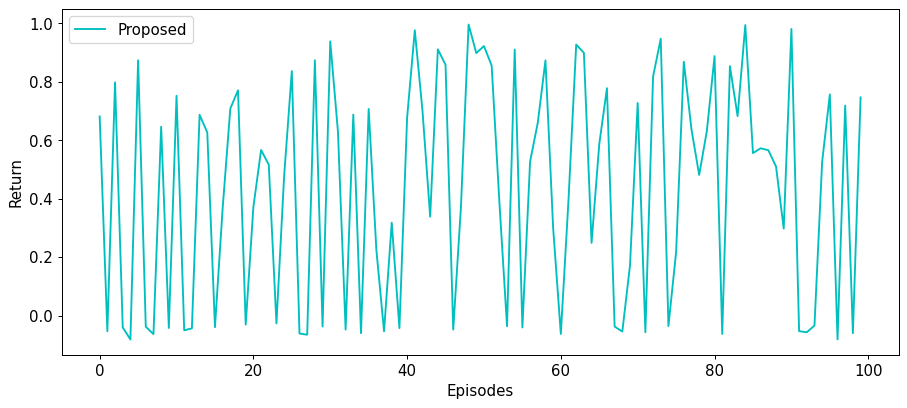

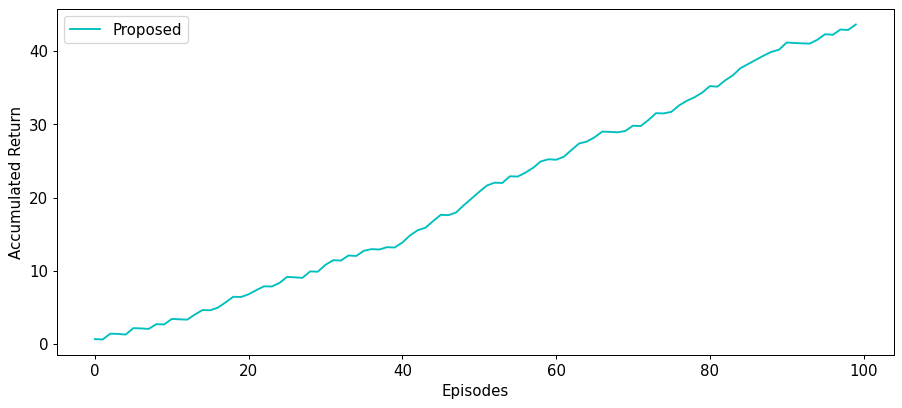

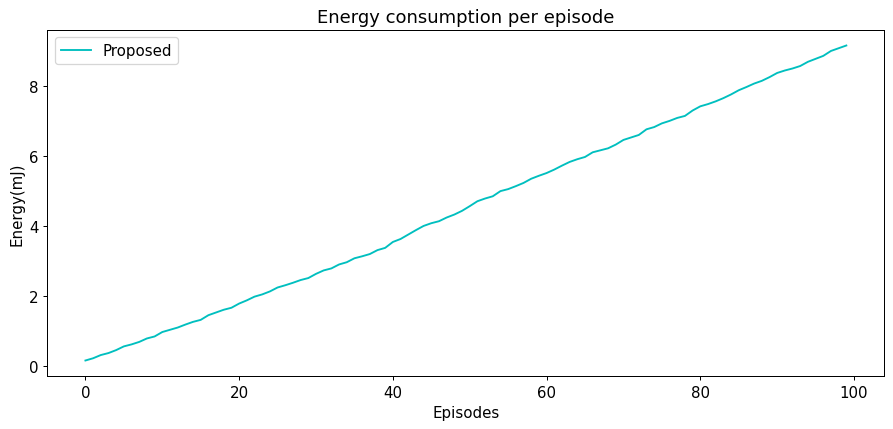

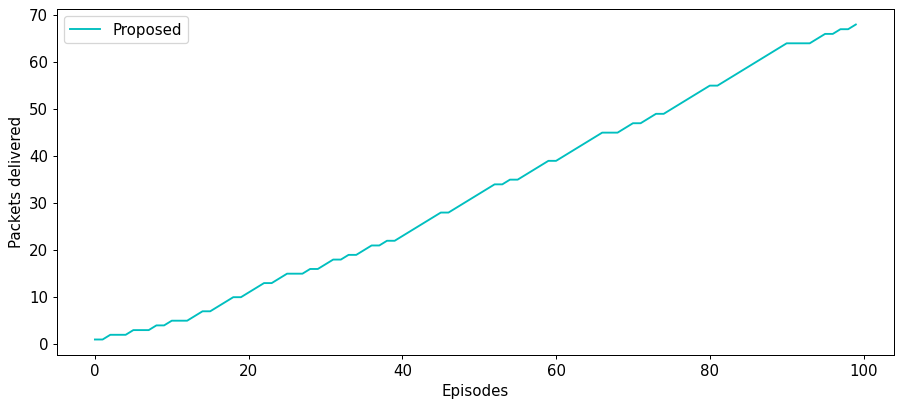

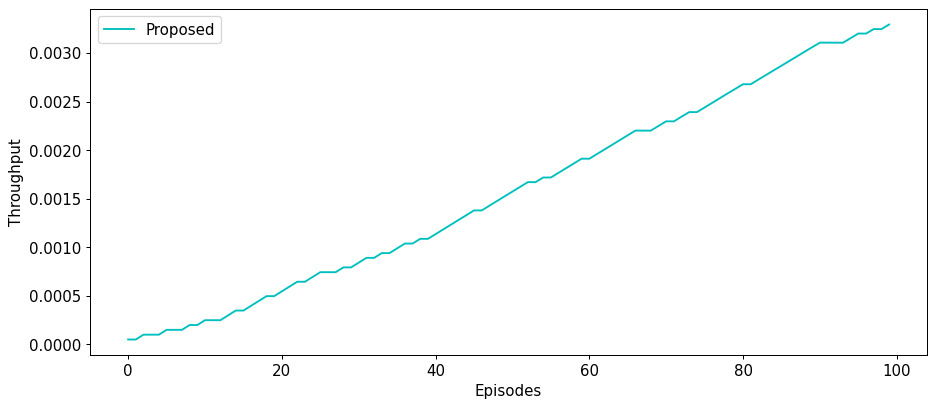

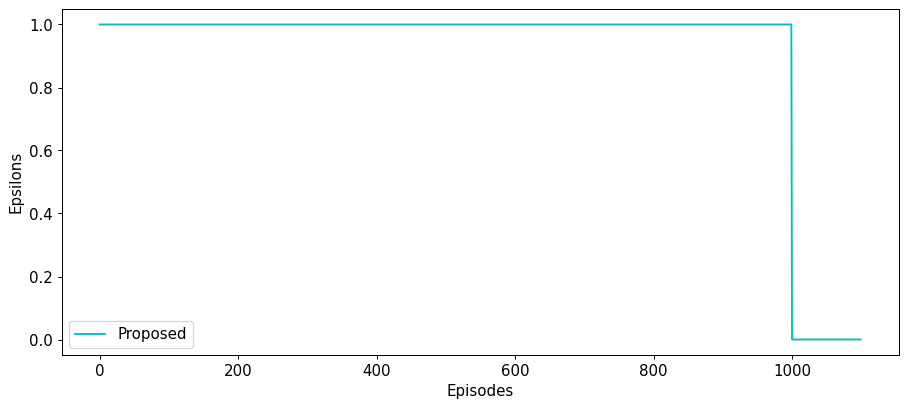

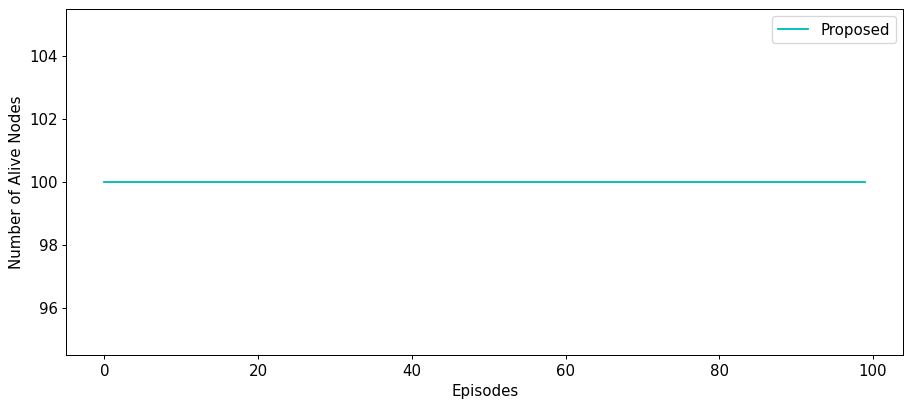

In [4]:

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(return_proposed)), return_proposed, color='c', label='Proposed')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(acc_return_proposed)), acc_return_proposed, color='c', label='Proposed')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Accumulated Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()

x2 = range(len(acc_energy_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, energy6, color='r', label='Proposed')
plt.plot(x2, acc_energy_proposed, color='c', label='Proposed')
# plt.plot(x2, energy2, color='b', label='R2LTO')
# plt.plot(x2, energy3, color='tab:orange', label='RLBR')
# plt.plot(x2, energy4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_energy_consumption, color='g', label='FMOLD')
# plt.plot(x, RSPAR_energy_consumption, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Energy(mJ)")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.title("Energy consumption per episode")
plt.show()

x = range(len(packets_delivered_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, delivery6, color='r', label='Proposed')
plt.plot(x, packets_delivered_proposed, color='c', label='Proposed')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Packets delivered")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(throughput_proposed)), throughput_proposed, color='c', label='Proposed')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Throughput")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(epsilons_proposed)), epsilons_proposed, color='c', label='Proposed')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Epsilons")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot networks' lifetime

x = range(len(alive_node_proposed))
plt.figure(figsize=(12, 5))
plt.plot(x, alive_node_proposed, color='c', label='Proposed')
# plt.plot(x, alive_node2, color='b', label='R2LTO')
# plt.plot(x, alive_node3, color='tab:orange', label='RLBR')
# plt.plot(x, alive_node4, color='tab:pink', label='RLBEEP')
plt.xlabel("Episodes")
plt.ylabel("Number of Alive Nodes")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

In [5]:
def get_next_action_baselines(q_table, current_row_index, current_column_index, epsilon=0):
    if np.random.random() > epsilon:
      return np.argmax(q_table[current_row_index, current_column_index])
    else: #choose a random action
      return np.random.randint(4)

# Learn from scratch in each subperiod
def Static_Q_learning(epsilone = 0.0, discount_factor = 0.9, learning_rate = 0.9, isTraining = True):

    # initial_preference_set = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    q_values = np.zeros((environment_rows, environment_columns, 4))
    env = WSN()

    epsilon_initial = 1.0
    epsilon_end = 0.0
    epsilon = epsilon_initial
    training_period = 1000
    exploration_period = 50
    epsilons_staticQ = [epsilon_initial]


    packets_deliered = []
    packet_delivery_rate = []
    t_energy = []
    t_return = []
    returns = []
    subepisode_packets_deliered = []
    subepisode_packet_delivery_rate = []
    subepisode_t_energy = []
    subepisode_energy_rate = []

    subepisode_reward_rate = []
    total_reward = 0
    subepisode_tot_reward = 0

    alive = []
    dead_nodes = []
    lifetime = []
    alive_node_count = environment_rows * environment_columns
    total_network_lifetime = 0

    time = 0
    throughput = []

    path_lenght = 0
    nb_success = 0
    total_energy = 0


    subepisode_tot_packets_deliered = 0
    subepisode_tot_energy = 0


    # define the initial energy of nodes
    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    subperiod_index = 0
    #run through 1000 training episodes
    for episode in range(number_of_episodes):
      print(episode)
      if episode < training_period:
        isTraining = True
        b=0.5
      elif episode == training_period:
        isTraining = False
        nb_success = 0
        total_energy = 0
        initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)
        alive_node_count = environment_rows * environment_columns
        subperiod_index = episode - duration_testing_subepisode
        b=episode_preferences[subperiod_index]
      else:
        subperiod_index = episode - duration_testing_subepisode
        b=episode_preferences[subperiod_index]
        isTraining = False


      epsilon = 0.7
      epsilons_staticQ.append(epsilon)

      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()

      #initialize the amount of consumed energy to zero for the curretn episode
      energy = 0
      path_lenght = 0

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until the data packet reaches the destination node or stuck wiht a malicious node)
      while not env.is_terminal_state(row_index, column_index):
          time += 1

          #perform the chosen action, and transition to the next state (i.e., move to the next node)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          action_index = get_next_action_baselines(q_values, row_index, column_index, epsilon)

          row_index, column_index = env.get_next_location(row_index, column_index, action_index)
          #receive the reward from SDN for moving to the new state
          delivery_reward = env.get_reward(row_index, column_index)
          temp_energy = transmission_energy_cost + 100 * active_mode_energy_cost

          reward = (1-b)*delivery_reward - b*temp_energy

          old_q_value = q_values[old_row_index, old_column_index, action_index]
          temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values[old_row_index, old_column_index, action_index] = new_q_value


          #calculate the current energy-level for all nodes
          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

           # add one step to path lenght
          path_lenght += 1
          total_network_lifetime += 1

          # if the energy level of any node is zero or less, it means that the node is died
          for row in range(environment_rows):
            for column in range(environment_columns):
              if initial_energy[row, column] <= 0 and (row, column) not in dead_nodes:
                  dead_nodes.append((row, column))
                  lifetime.append(total_network_lifetime)
                  alive_node_count -= 1

          # If we have a reward, it means that the packet has been delivered to the sink node
          if delivery_reward == 1:
              nb_success += 1
              subepisode_tot_packets_deliered += 1


      if isTraining == False:
        alive.append(alive_node_count)
        packets_deliered.append(nb_success)
        throughput.append(nb_success/time)
        packet_delivery_rate.append(nb_success/(episode+1))
        energy = path_lenght*transmission_energy_cost + 100 * active_mode_energy_cost
        total_energy += energy
        total_reward += (1-b)*delivery_reward - b*energy
        returns.append((1-b)*delivery_reward - b*energy)
        t_energy.append(total_energy)
        t_return.append(total_reward)

        subepisode_number = (episode-training_episodes)%duration_testing_subepisode
        subepisode_tot_energy += energy
        subepisode_tot_reward += (1-b)*delivery_reward - b*energy
        subepisode_packet_delivery_rate.append(subepisode_tot_packets_deliered/(subepisode_number+1))
        subepisode_energy_rate.append(subepisode_tot_energy/(subepisode_number+1))
        subepisode_reward_rate.append(subepisode_tot_reward/(subepisode_number+1))

    if len(lifetime) == 0:
      lifetime.append(number_of_episodes-training_episodes)

    life = []
    for x in range(number_of_episodes):
      life.append(x)

    print('Q-learning Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success/(episode+1-training_episodes))
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return(packets_deliered, packet_delivery_rate, returns, t_return, t_energy, alive, subepisode_packet_delivery_rate, subepisode_energy_rate, subepisode_reward_rate, epsilons_staticQ, throughput)

packets_delivered_staticQ, delivery_rate_staticQ , return_staticQ, acc_return_staticQ, acc_energy_staticQ, alive_node_staticQ, subepisode_packet_delivery_rate_staticQ, subepisode_energy_rate_staticQ, subepisode_reward_rate_staticQ, epsilons_staticQ, throughput_staticQ = Static_Q_learning()

0
MALICIOUS NODE REACHED
1
MALICIOUS NODE REACHED
2
MALICIOUS NODE REACHED
3
MALICIOUS NODE REACHED
4
MALICIOUS NODE REACHED
5
MALICIOUS NODE REACHED
6
MALICIOUS NODE REACHED
7
MALICIOUS NODE REACHED
8
MALICIOUS NODE REACHED
9
MALICIOUS NODE REACHED
10
MALICIOUS NODE REACHED
11
MALICIOUS NODE REACHED
12
MALICIOUS NODE REACHED
13
SINK NODE REACHED
14
MALICIOUS NODE REACHED
15
MALICIOUS NODE REACHED
16
MALICIOUS NODE REACHED
17
MALICIOUS NODE REACHED
18
MALICIOUS NODE REACHED
19
MALICIOUS NODE REACHED
20
MALICIOUS NODE REACHED
21
MALICIOUS NODE REACHED
22
MALICIOUS NODE REACHED
23
MALICIOUS NODE REACHED
24
MALICIOUS NODE REACHED
25
MALICIOUS NODE REACHED
26
MALICIOUS NODE REACHED
27
MALICIOUS NODE REACHED
28
MALICIOUS NODE REACHED
29
MALICIOUS NODE REACHED
30
MALICIOUS NODE REACHED
31
MALICIOUS NODE REACHED
32
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
33
MALICIOUS NODE REACHED
34
MALICIOUS NODE REACHED
35
MALICIOUS NODE REACHED
36
MALICIOUS NODE REACHED
37
MALICIOUS NODE REACHED
38
M

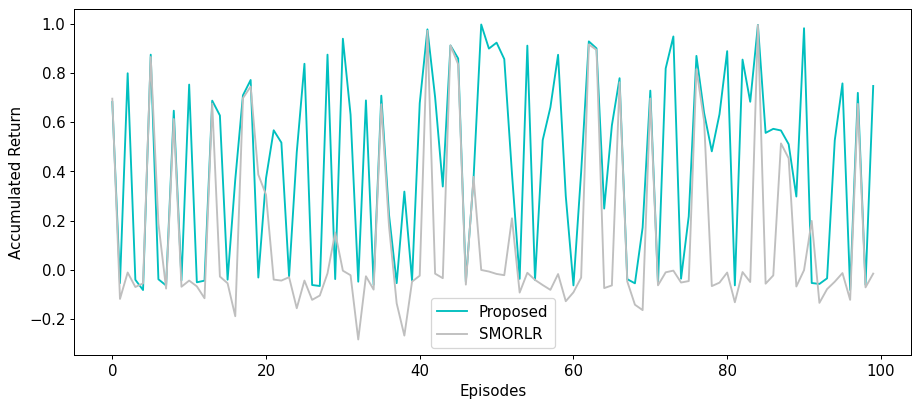

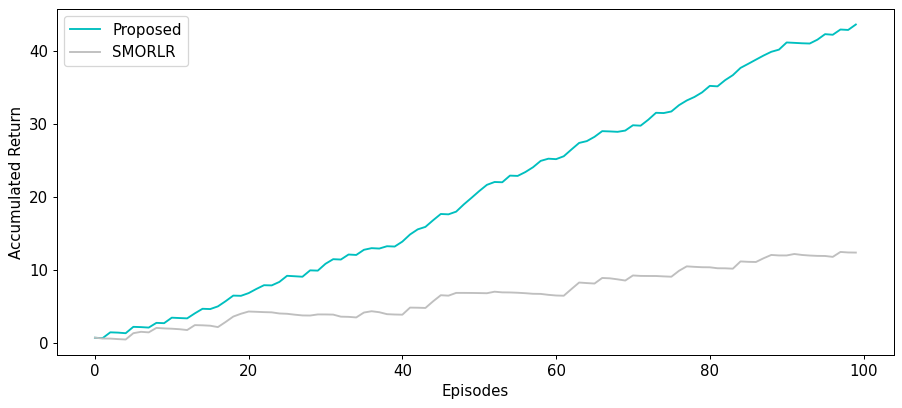

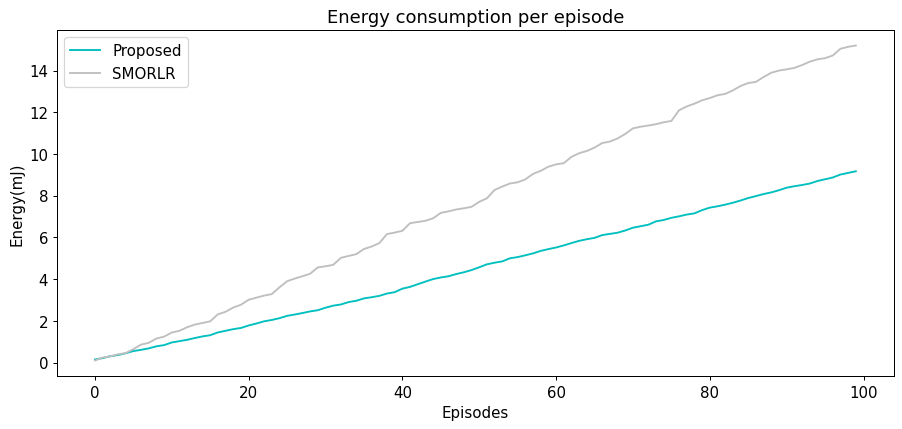

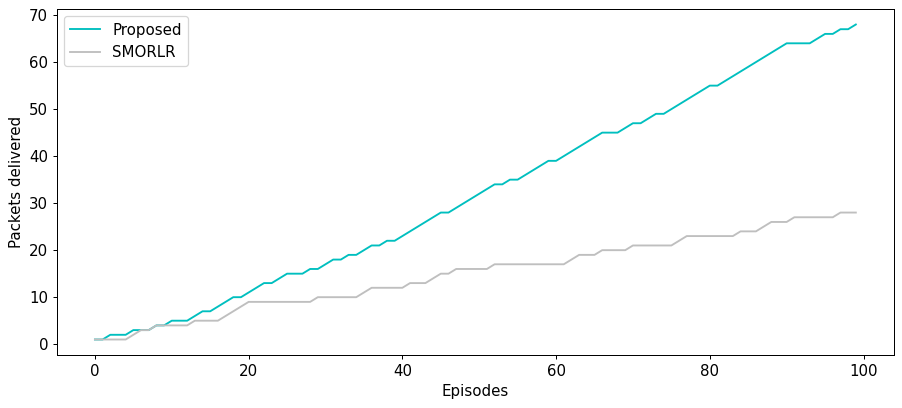

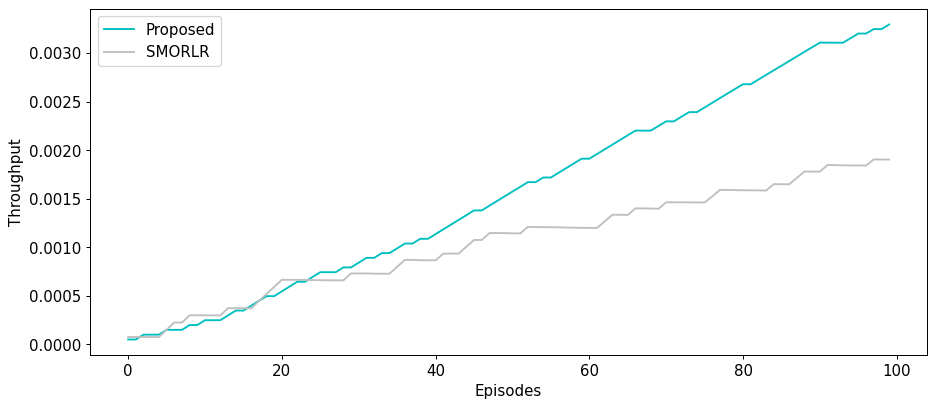

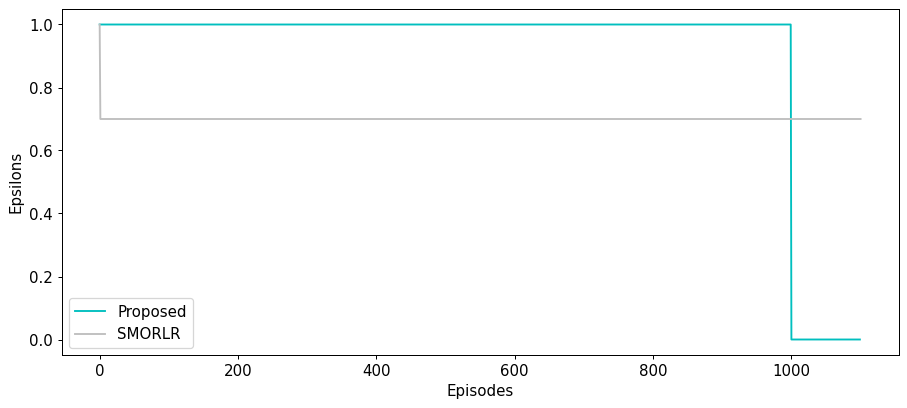

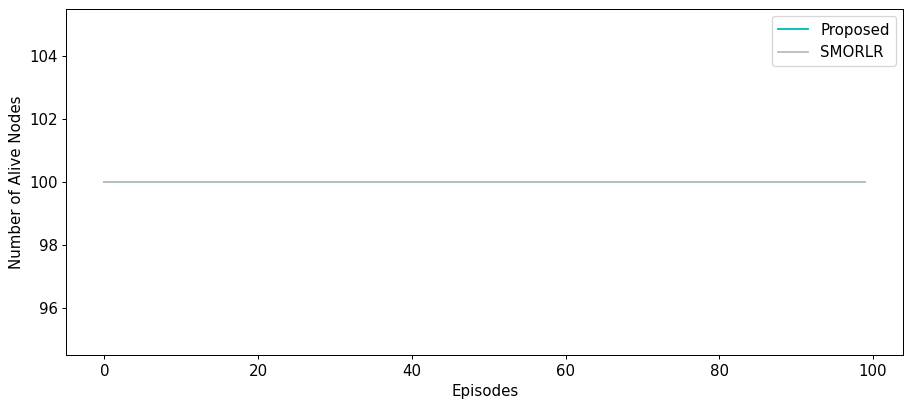

In [6]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(return_proposed)), return_proposed, color='c', label='Proposed')
plt.plot(range(len(return_staticQ)), return_staticQ, color='0.75', label='SMORLR')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Accumulated Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(acc_return_proposed)), acc_return_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_return_staticQ)), acc_return_staticQ, color='0.75', label='SMORLR')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Accumulated Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()

x2 = range(len(acc_energy_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, energy6, color='r', label='Proposed')
plt.plot(x2, acc_energy_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_energy_staticQ)), acc_energy_staticQ, color='0.75', label='SMORLR')
# plt.plot(x2, energy2, color='b', label='R2LTO')
# plt.plot(x2, energy3, color='tab:orange', label='RLBR')
# plt.plot(x2, energy4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_energy_consumption, color='g', label='FMOLD')
# plt.plot(x, RSPAR_energy_consumption, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Energy(mJ)")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.title("Energy consumption per episode")
plt.show()

x = range(len(packets_delivered_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, delivery6, color='r', label='Proposed')
plt.plot(x, packets_delivered_proposed, color='c', label='Proposed')
plt.plot(range(len(packets_delivered_staticQ)), packets_delivered_staticQ, color='0.75', label='SMORLR')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Packets delivered")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(throughput_proposed)), throughput_proposed, color='c', label='Proposed')
plt.plot(range(len(throughput_staticQ)), throughput_staticQ, color='0.75', label='SMORLR')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Throughput")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(epsilons_proposed)), epsilons_proposed, color='c', label='Proposed')
plt.plot(range(len(epsilons_staticQ)), epsilons_staticQ, color = '0.75', label='SMORLR')
# plt.plot(x, delivery2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Epsilons")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot networks' lifetime

x = range(len(alive_node_proposed))
plt.figure(figsize=(12, 5))
plt.plot(x, alive_node_proposed, color='c', label='Proposed')
plt.plot(x, alive_node_staticQ, color = '0.75', label='SMORLR')
# plt.plot(x, alive_node2, color='b', label='R2LTO')
# plt.plot(x, alive_node3, color='tab:orange', label='RLBR')
# plt.plot(x, alive_node4, color='tab:pink', label='RLBEEP')
plt.xlabel("Episodes")
plt.ylabel("Number of Alive Nodes")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

In [7]:
"""
Algorithm based on work done by Bouzid et al. (2020).

Bouzid, S. E., Serrestou, Y., Raoof, K., & Omri, M. N. (2020). Efficient routing protocol for wireless sensor network based on reinforcement learning. In 2020 5th International Conference on Advanced Technologies for Signal and Image Processing (ATSIP) (pp. 1-5). IEEE. 10.1109/ATSIP49331.2020.9231883

"""


def R2LTO(discount_factor = 0.2, learning_rate = 0.9):
    q_values = np.zeros((environment_rows, environment_columns, 4))
    env = WSN()
    isTraining = True

    epsilon_initial = 1.0
    epsilon_end = 0.0
    training_period = 1000
    exploration_period = 50


    packet_delivery = []
    t_energy = []
    t_return = []
    returns = []
    subepisode_packets_deliered = []
    subepisode_packet_delivery_rate = []
    subepisode_t_energy = []
    subepisode_energy_rate = []

    subepisode_tot_packets_deliered = 0
    subepisode_tot_energy = 0

    path_lenght = 0
    nb_success = 0
    total_energy = 0
    #hop = 0

    subepisode_reward_rate = []
    total_reward = 0
    subepisode_tot_reward = 0

    alive = []
    dead_nodes = []
    lifetime = []
    alive_node_count = environment_rows * environment_columns
    total_network_lifetime = 0
    epsilons2 = []
    packets_delivered = []

    time = 0
    throughput = []

    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    subperiod_index = 0
    #run through all the episodes
    for episode in range(number_of_episodes):
      eps_decay_rate = max((training_period-episode)/training_period, 0)
      epsilon = (epsilon_initial - epsilon_end)*eps_decay_rate + epsilon_end

      if episode < training_period:
        isTraining = True
        b=0.5
      elif episode == training_period:
        isTraining = False
        nb_success = 0
        total_energy = 0
        subperiod_index = episode - duration_testing_subepisode
        b=episode_preferences[subperiod_index]
        initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)
        alive_node_count = environment_rows * environment_columns
      else:
        subperiod_index = episode - duration_testing_subepisode
        b=episode_preferences[subperiod_index]
        isTraining = False

      epsilon = 0.7
      epsilons2.append(epsilon)

      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()

      #initialize the consumed energy to zero for the curretn episode
      energy = 0
      path_lenght = 0
      alive_node = environment_rows * environment_columns

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until we reach the item packaging area or crash into an item storage location)
      while not env.is_terminal_state(row_index, column_index):
          time += 1
          #choose which action to take (i.e., where to move next)
          action_index = get_next_action_baselines(q_values, row_index, column_index, epsilon)

          #perform the chosen action, and transition to the next state (i.e., move to the next location)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)

          #calculate the reward for moving to the new state
          delivery_reward = env.get_reward(row_index, column_index)
          hop = 18-row_index-column_index
          R = initial_energy[row_index, column_index]/(hop+1)


          old_q_value = q_values[old_row_index, old_column_index, action_index]
          temporal_difference = R + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values[old_row_index, old_column_index, action_index] = new_q_value


          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

          # if the energy level of any node is zero or less, it means that the node is died
          for row in range(environment_rows):
            for column in range(environment_columns):
              if initial_energy[row, column] <= 0 and (row, column) not in dead_nodes:
                  dead_nodes.append((row, column))
                  lifetime.append(total_network_lifetime)
                  alive_node_count -= 1

          # If we have the delivery-reward as 1, it means that our outcome is a success
          if delivery_reward == 1:
              nb_success += 1
              subepisode_tot_packets_deliered += 1

          # add one step to path lenght
          path_lenght += 1

      if isTraining == False:
        alive.append(alive_node_count)
        packets_delivered.append(nb_success)
        packet_delivery.append(nb_success/(episode+1))
        throughput.append(nb_success/time)
        energy = path_lenght*transmission_energy_cost + 100*active_mode_energy_cost
        total_energy += energy
        total_reward += (1-b)*delivery_reward - b*energy
        t_energy.append(total_energy)
        t_return.append(total_reward)
        returns.append((1-b)*delivery_reward - b*energy)

        subepisode_number = (episode - training_period)%duration_testing_subepisode
        subepisode_tot_energy += energy
        subepisode_packet_delivery_rate.append(subepisode_tot_packets_deliered/(subepisode_number+1))
        subepisode_energy_rate.append(subepisode_tot_energy/(subepisode_number+1))
        subepisode_tot_reward += (1-b)*delivery_reward - b*energy
        subepisode_reward_rate.append(subepisode_tot_reward/(subepisode_number+1))

    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return(packets_delivered, returns, t_return, t_energy, alive, subepisode_packet_delivery_rate, subepisode_energy_rate, subepisode_reward_rate, epsilons2, throughput)

packets_delivered2 , return2, acc_return2, acc_energy2, alive_node2, subepisode_packet_delivery_rate2, subepisode_energy_rate2, subepisode_reward_rate2, epsilons2, throughput2 = R2LTO()

MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED


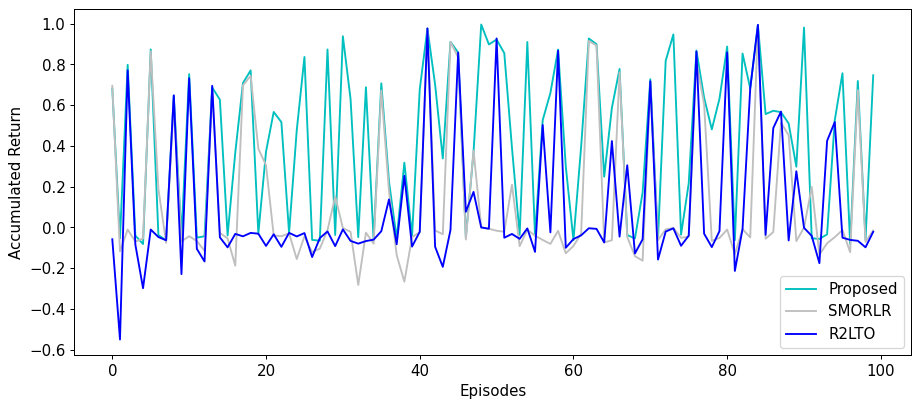

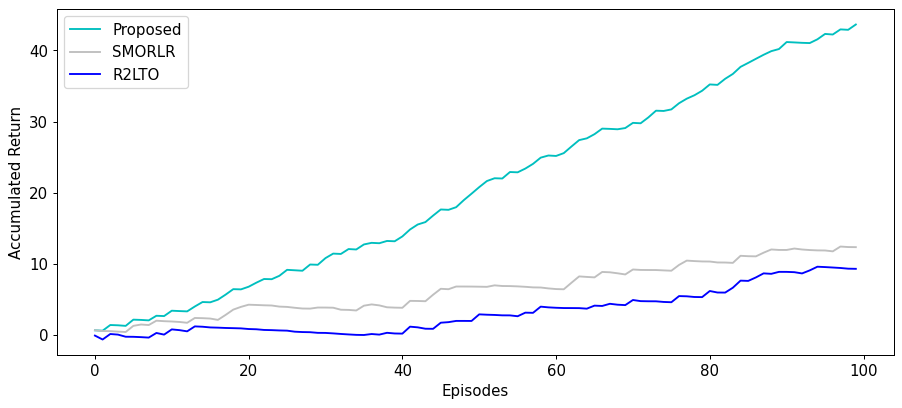

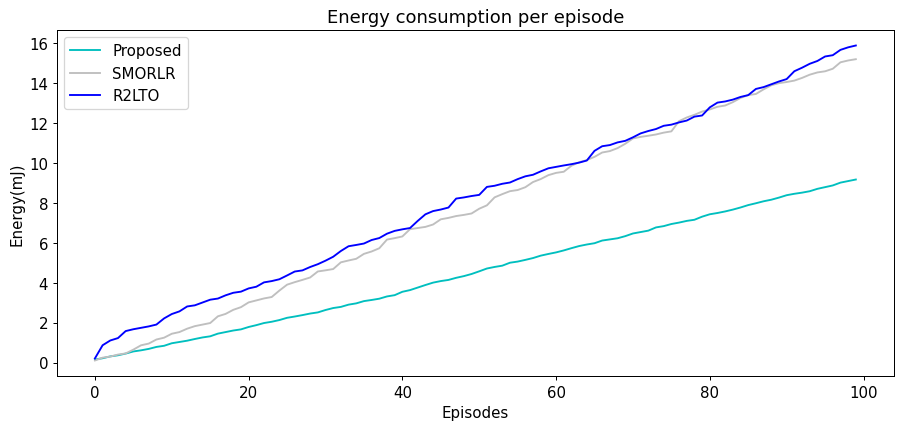

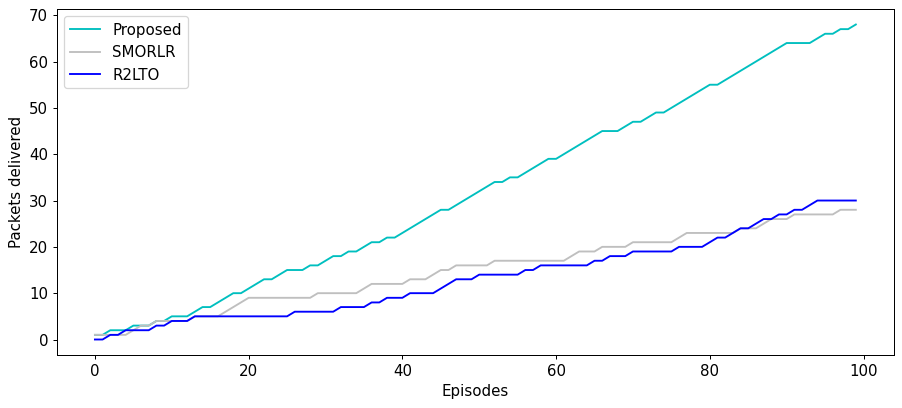

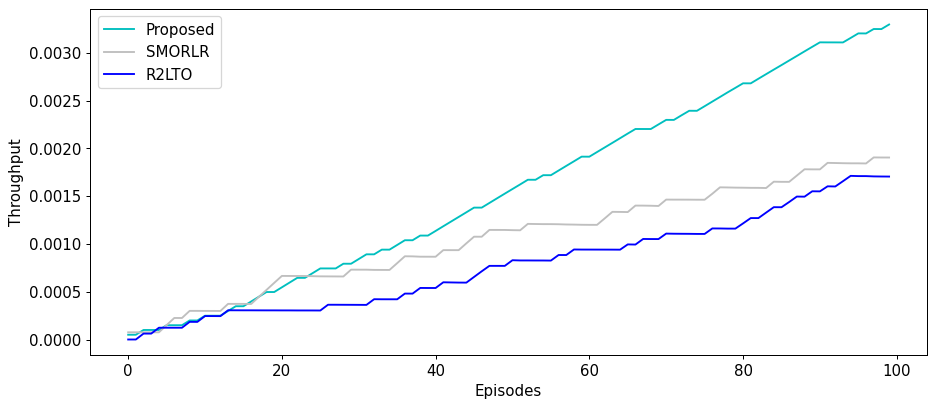

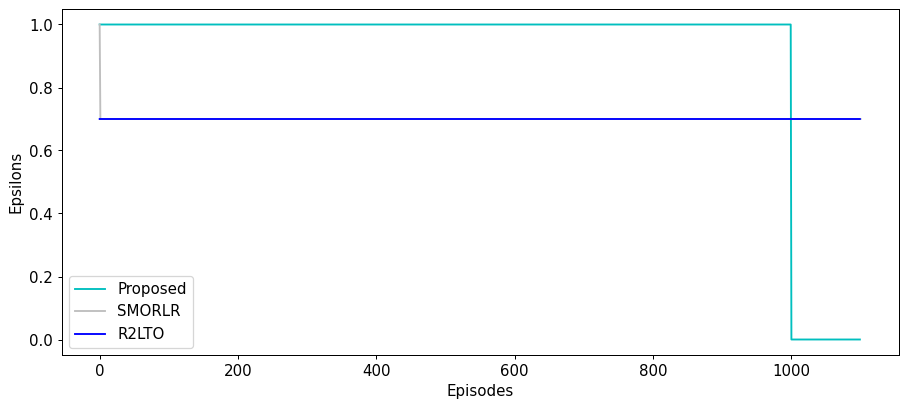

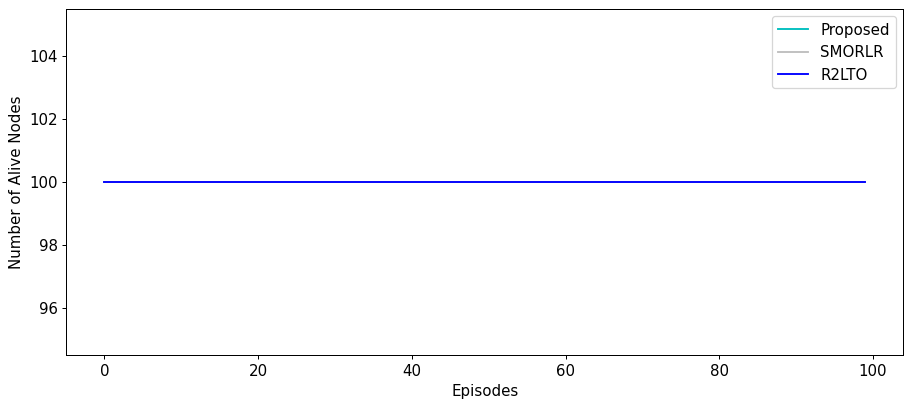

In [8]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(return_proposed)), return_proposed, color='c', label='Proposed')
plt.plot(range(len(return_staticQ)), return_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(return2)), return2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Accumulated Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(acc_return_proposed)), acc_return_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_return_staticQ)), acc_return_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_return2)), acc_return2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Accumulated Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()

x2 = range(len(acc_energy_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, energy6, color='r', label='Proposed')
plt.plot(x2, acc_energy_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_energy_staticQ)), acc_energy_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_energy2)), acc_energy2, color='b', label='R2LTO')
# plt.plot(x2, energy3, color='tab:orange', label='RLBR')
# plt.plot(x2, energy4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_energy_consumption, color='g', label='FMOLD')
# plt.plot(x, RSPAR_energy_consumption, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Energy(mJ)")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.title("Energy consumption per episode")
plt.show()

x = range(len(packets_delivered_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, delivery6, color='r', label='Proposed')
plt.plot(x, packets_delivered_proposed, color='c', label='Proposed')
plt.plot(range(len(packets_delivered_staticQ)), packets_delivered_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(packets_delivered2)), packets_delivered2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Packets delivered")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(throughput_proposed)), throughput_proposed, color='c', label='Proposed')
plt.plot(range(len(throughput_staticQ)), throughput_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(throughput2)), throughput2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Throughput")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(epsilons_proposed)), epsilons_proposed, color='c', label='Proposed')
plt.plot(range(len(epsilons_staticQ)), epsilons_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(epsilons2)), epsilons2, color='b', label='R2LTO')
# plt.plot(x, delivery3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Epsilons")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot networks' lifetime

x = range(len(alive_node_proposed))
plt.figure(figsize=(12, 5))
plt.plot(x, alive_node_proposed, color='c', label='Proposed')
plt.plot(range(len(alive_node_staticQ)), alive_node_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(alive_node2)), alive_node2, color='b', label='R2LTO')
# plt.plot(x, alive_node3, color='tab:orange', label='RLBR')
# plt.plot(x, alive_node4, color='tab:pink', label='RLBEEP')
plt.xlabel("Episodes")
plt.ylabel("Number of Alive Nodes")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

In [9]:
def RLBR(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9):
    q_values = np.zeros((environment_rows, environment_columns, 4))
    env = WSN()
    isTraining = True

    epsilon_initial = 1.0
    epsilon_end = 0.0
    training_period = 1000
    exploration_period = 50

    packet_delivery = []
    t_energy = []
    t_return = []
    returns = []
    subepisode_packets_deliered = []
    subepisode_packet_delivery_rate = []
    subepisode_t_energy = []
    subepisode_energy_rate = []

    subepisode_tot_packets_deliered = 0
    subepisode_tot_energy = 0

    path_lenght = 0
    nb_success = 0
    total_energy = 0
    #hop = 0

    subepisode_reward_rate = []
    total_reward = 0
    subepisode_tot_reward = 0

    alive = []
    dead_nodes = []
    lifetime = []
    alive_node_count = environment_rows * environment_columns
    total_network_lifetime = 0
    epsilons3 = []
    packets_delivered = []

    time = 0
    throughput = []

    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    subperiod_index = 0
    #run through all the episodes
    for episode in range(number_of_episodes):
      eps_decay_rate = max((training_period-episode)/training_period, 0)
      epsilon = (epsilon_initial - epsilon_end)*eps_decay_rate + epsilon_end

      if episode < training_period:
        isTraining = True
        b=0.5
      elif episode == training_period:
        isTraining = False
        nb_success = 0
        total_energy = 0
        subperiod_index = episode - duration_testing_subepisode
        b=episode_preferences[subperiod_index]
        initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)
        alive_node_count = environment_rows * environment_columns
      else:
        subperiod_index = episode - duration_testing_subepisode
        b=episode_preferences[subperiod_index]
        isTraining = False

      epsilon = 0.7
      epsilons2.append(epsilon)

      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()

      #initialize the consumed energy to zero for the current episode
      energy = 0
      path_lenght = 0
      alive_node = environment_rows * environment_columns

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until we reach the item packaging area or crash into an item storage location)
      while not env.is_terminal_state(row_index, column_index):
          time += 1
          #choose which action to take (i.e., where to move next)
          action_index = get_next_action_baselines(q_values, row_index, column_index, epsilon)

          #perform the chosen action, and transition to the next state (i.e., move to the next location)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)

          #calculate the reward for moving to the new state
          hop = 18-row_index-column_index
          delivery_reward = env.get_reward(row_index, column_index)
          R = initial_energy[row_index, column_index]/(9 ** 2 *(hop+1))


          old_q_value = q_values[old_row_index, old_column_index, action_index]
          temporal_difference = R + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values[old_row_index, old_column_index, action_index] = new_q_value

          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

          # if the energy level of any node is zero or less, it means that the node is died
          for row in range(environment_rows):
            for column in range(environment_columns):
              if initial_energy[row, column] <= 0 and (row, column) not in dead_nodes:
                  dead_nodes.append((row, column))
                  lifetime.append(total_network_lifetime)
                  alive_node_count -= 1

          # If we have the delivery-reward as 1, it means that our outcome is a success
          if delivery_reward == 1:
              nb_success += 1
              subepisode_tot_packets_deliered += 1

          # add one step to path lenght
          path_lenght += 1


      if isTraining == False:
        alive.append(alive_node_count)
        packets_delivered.append(nb_success)
        packet_delivery.append(nb_success/(episode+1))
        throughput.append(nb_success/time)
        energy = path_lenght*transmission_energy_cost + 100*active_mode_energy_cost
        total_energy += energy
        total_reward += (1-b)*delivery_reward - b*energy
        t_energy.append(total_energy)
        t_return.append(total_reward)
        returns.append((1-b)*delivery_reward - b*energy)

        subepisode_number = (episode - training_period)%duration_testing_subepisode
        subepisode_tot_energy += energy
        subepisode_packet_delivery_rate.append(subepisode_tot_packets_deliered/(subepisode_number+1))
        subepisode_energy_rate.append(subepisode_tot_energy/(subepisode_number+1))
        subepisode_tot_reward += (1-b)*delivery_reward - b*energy
        subepisode_reward_rate.append(subepisode_tot_reward/(subepisode_number+1))


    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / (episode+1))
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return(packets_delivered, returns, t_return, t_energy, alive, subepisode_packet_delivery_rate, subepisode_energy_rate, subepisode_reward_rate, epsilons3, throughput)

packets_delivered3 , return3, acc_return3, acc_energy3, alive_node3, subepisode_packet_delivery_rate3, subepisode_energy_rate3, subepisode_reward_rate3, epsilons3, throughput3 = RLBR()

MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
SINK NODE REACHED
MALIC

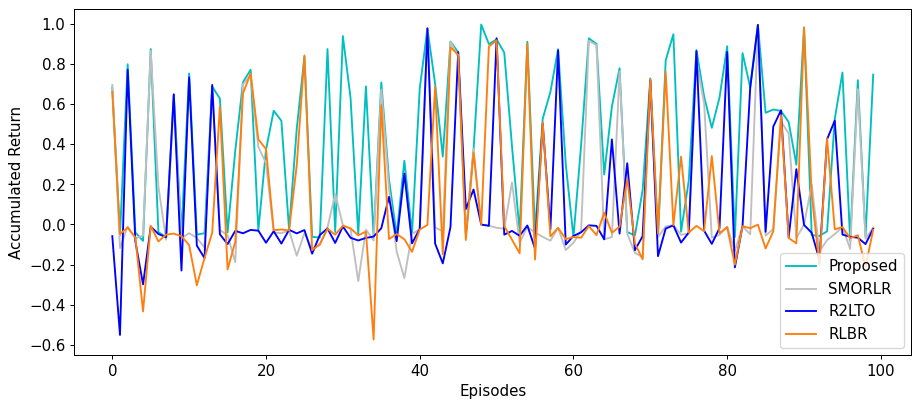

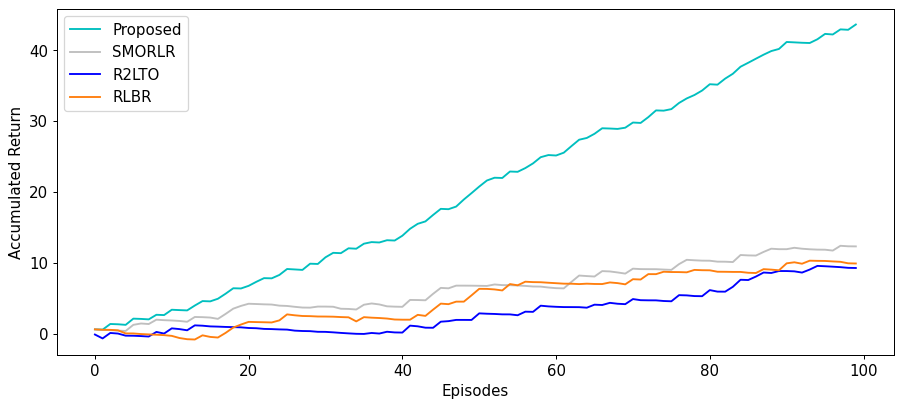

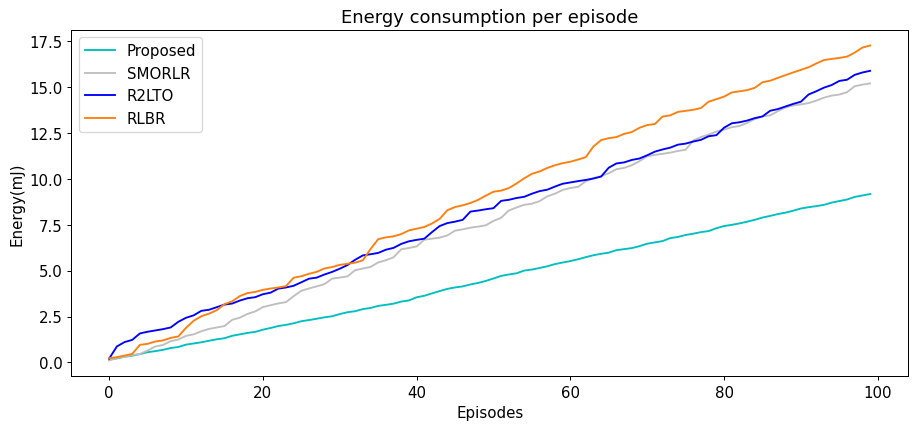

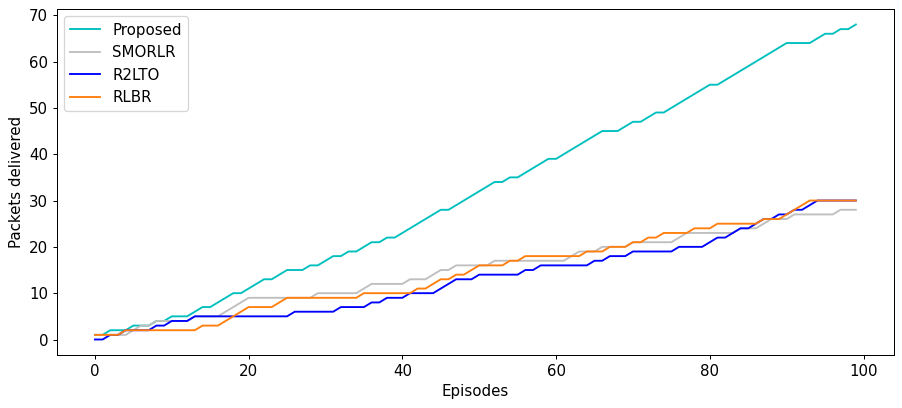

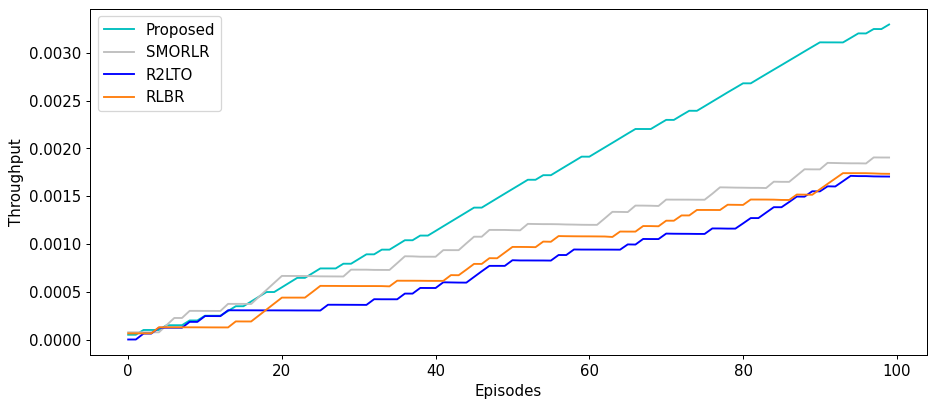

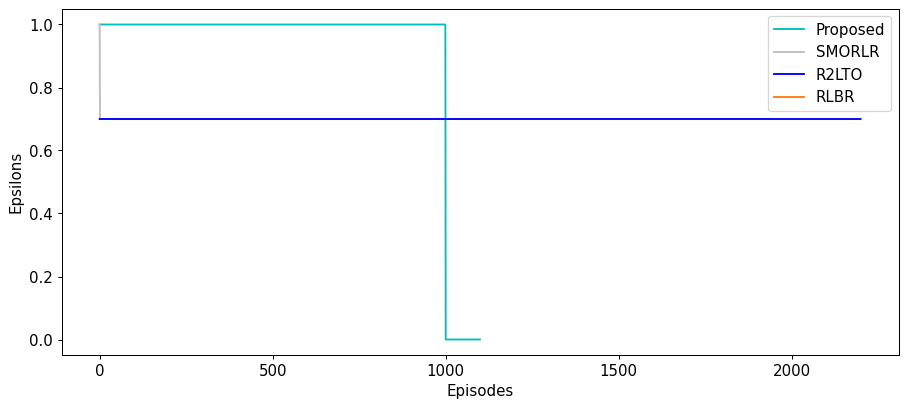

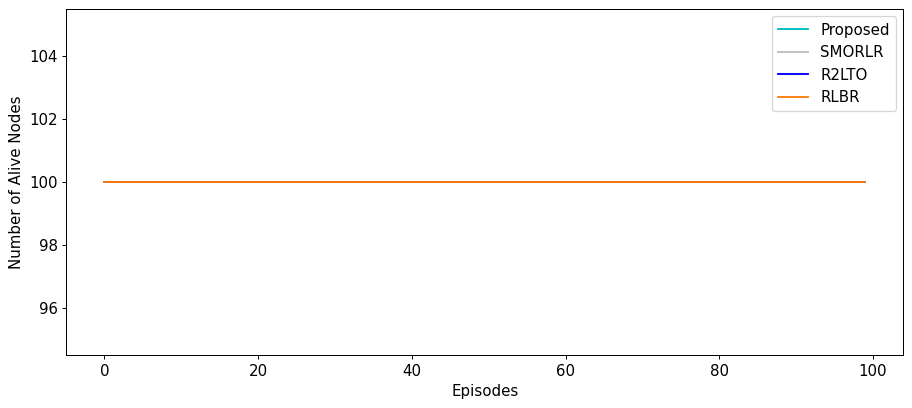

In [10]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(return_proposed)), return_proposed, color='c', label='Proposed')
plt.plot(range(len(return_staticQ)), return_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(return2)), return2, color='b', label='R2LTO')
plt.plot(range(len(return3)), return3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Accumulated Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(acc_return_proposed)), acc_return_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_return_staticQ)), acc_return_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_return2)), acc_return2, color='b', label='R2LTO')
plt.plot(range(len(acc_return3)), acc_return3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Accumulated Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()

x2 = range(len(acc_energy_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, energy6, color='r', label='Proposed')
plt.plot(x2, acc_energy_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_energy_staticQ)), acc_energy_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_energy2)), acc_energy2, color='b', label='R2LTO')
plt.plot(range(len(acc_energy3)), acc_energy3, color='tab:orange', label='RLBR')
# plt.plot(x2, energy4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_energy_consumption, color='g', label='FMOLD')
# plt.plot(x, RSPAR_energy_consumption, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Energy(mJ)")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.title("Energy consumption per episode")
plt.show()

x = range(len(packets_delivered_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, delivery6, color='r', label='Proposed')
plt.plot(x, packets_delivered_proposed, color='c', label='Proposed')
plt.plot(range(len(packets_delivered_staticQ)), packets_delivered_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(packets_delivered2)), packets_delivered2, color='b', label='R2LTO')
plt.plot(range(len(packets_delivered3)), packets_delivered3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Packets delivered")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(throughput_proposed)), throughput_proposed, color='c', label='Proposed')
plt.plot(range(len(throughput_staticQ)), throughput_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(throughput2)), throughput2, color='b', label='R2LTO')
plt.plot(range(len(throughput3)), throughput3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Throughput")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(epsilons_proposed)), epsilons_proposed, color='c', label='Proposed')
plt.plot(range(len(epsilons_staticQ)), epsilons_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(epsilons2)), epsilons2, color='b', label='R2LTO')
plt.plot(range(len(epsilons3)), epsilons3, color='tab:orange', label='RLBR')
# plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Epsilons")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot networks' lifetime

x = range(len(alive_node_proposed))
plt.figure(figsize=(12, 5))
plt.plot(x, alive_node_proposed, color='c', label='Proposed')
plt.plot(range(len(alive_node_staticQ)), alive_node_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(alive_node2)), alive_node2, color='b', label='R2LTO')
plt.plot(range(len(alive_node3)), alive_node3, color='tab:orange', label='RLBR')
# plt.plot(x, alive_node4, color='tab:pink', label='RLBEEP')
plt.xlabel("Episodes")
plt.ylabel("Number of Alive Nodes")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

In [13]:
# functions and parameters for RLBEEP algorithm
MND_lon, MND_lat = environment_rows, environment_columns
DFR_min = 5
DFR_max = 55
sleep_counter = np.zeros((environment_rows, environment_columns), dtype=int)
sleep_thresh = 5
sleep_mode_energy_cost = 0

def get_distance(row1, col1, row2, col2):
    return np.sqrt((row1 - row2) ** 2 + (col1 - col2) ** 2)

def get_normalized_distance(row1, col1, row2, col2):
    return get_distance(row1, col1, row2, col2) / max(MND_lon, MND_lat)

# get n
def get_n(row1, col1, row2, col2):
    normalized_distance = get_normalized_distance(row1, col1, row2, col2)
    return (normalized_distance * (DFR_max - DFR_min)) + DFR_min


#
def restrict_data_transmission(prev_min, prev_max, sensor_data, threshold):
    curr_min = min(prev_min, sensor_data)
    curr_max = max(prev_max, sensor_data)
    send_permit = bool(abs(curr_max - sensor_data) > threshold or abs(sensor_data - curr_min) > threshold)
    return send_permit, curr_min, curr_max


#
def sleep_scheduling(row, col, send_permit, sleep_thresh, sleep_counter):
    if send_permit:
        sleep_counter[row, col] = 0
    else:
        sleep_counter[row, col] += 1

    if sleep_counter[row, col] > sleep_thresh:
        return 'sleep'
    else:
        return 'active'


def check_sleep_mode(row, col):
    if sleep_counter[row, col] > sleep_thresh:
        return 'sleep'
    else:
        return 'active'


#
def RLBEEP(epsilone=0, discount_factor=0.2, learning_rate=0.9):
    q_values = np.zeros((environment_rows, environment_columns, 4))
    env = WSN()

    epsilon_initial = 1.0
    epsilon_end = 0.0
    training_period = 1000
    exploration_period = 50

    packet_delivery = []
    t_energy = []
    t_return = []
    returns = []

    subepisode_packets_deliered = []
    subepisode_packet_delivery_rate = []
    subepisode_t_energy = []
    subepisode_energy_rate = []

    subepisode_tot_packets_deliered = 0
    subepisode_tot_energy = 0

    subepisode_reward_rate = []
    total_reward = 0
    subepisode_tot_reward = 0

    path_lenght = 0
    nb_success = 0
    total_energy = 0
    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)
    isTraining = True
    subperiod_index = 0
    success_probability = 0.25

    alive = []
    dead_nodes = []
    lifetime = []
    alive_node_count = environment_rows * environment_columns
    total_network_lifetime = 0
    epsilons4 = []
    packets_delivered = []

    time = 0
    throughput = []

    # run through 1000 training episodes
    for episode in range(number_of_episodes):
        eps_decay_rate = max((training_period-episode)/training_period, 0)
        epsilon = (epsilon_initial - epsilon_end)*eps_decay_rate + epsilon_end

        if episode < training_period:
          isTraining = True
          b=0.5
        elif episode == training_period:
          isTraining = False
          nb_success = 0
          total_energy = 0
          subperiod_index = episode - duration_testing_subepisode
          b=episode_preferences[subperiod_index]
          initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)
          alive_node_count = environment_rows * environment_columns
        else:
          subperiod_index = episode - duration_testing_subepisode
          b=episode_preferences[subperiod_index]
          isTraining = False

        epsilon = 0.7
        epsilons4.append(epsilon)

        #get the starting location for this episode
        row_index, column_index = env.get_starting_location()

        # initialize the consumed energy to zero for the curretn episode
        energy = 0
        path_lenght = 0

        prev_min = float('inf')
        prev_max = -float('inf')

        # continue taking actions (i.e., moving) until we reach a terminal state
        # (i.e., until we reach the item packaging area or crash into an item storage location)
        while not env.is_terminal_state(row_index, column_index):
            time += 1
            data_transmission_threshold = 3
            # mock temperature sensor data (random.randint(-10, 40))
            send_permit, prev_min, prev_max = restrict_data_transmission(prev_min, prev_max, random.randint(-10, 40),
                                                                         data_transmission_threshold)
            node_state = sleep_scheduling(row_index, column_index, send_permit, sleep_thresh=sleep_thresh,
                                          sleep_counter=sleep_counter)

            if node_state == 'active':
                # choose which action to take (i.e., where to move next)
                # action_index = env.get_next_action(row_index, column_index, epsilone)
                action_index = get_next_action_baselines(q_values, row_index, column_index, epsilon)

                # perform the chosen action, and transition to the next state (i.e., move to the next location)
                old_row_index, old_column_index = row_index, column_index  # store the old row and column indexes
                row_index, column_index = env.get_next_location(row_index, column_index, action_index)

                # calculate the reward for moving to the new state
                delivery_reward = env.get_reward(row_index, column_index)
                # calculate the remaining number of hops needed to reach the destination node
                hop = 18 - row_index - column_index
                # represents the energy reward for moving to the next state (location) in the reinforcement learning algorithm.
                d = get_distance(row_index, column_index, old_row_index, old_column_index)
                R = initial_energy[row_index, column_index] / ((hop + 1) * (9 ** get_n(row_index, column_index, old_row_index, old_column_index)))

                old_q_value = q_values[old_row_index, old_column_index, action_index]
                temporal_difference = R + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

                # update the Q-value for the previous state and action pair
                new_q_value = old_q_value + (learning_rate * temporal_difference)
                q_values[old_row_index, old_column_index, action_index] = new_q_value

                # update the energy level of all node (node consume energy if turn on active mode)

                initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

                # add one step to path lenght
                path_lenght += 1
                # add one step to total network lifetime
                total_network_lifetime += 1

                # if the energy level of any node is zero or less, it means that the node is died
                for row in range(environment_rows):
                    for column in range(environment_columns):
                        if check_sleep_mode(row, column) == 'sleep':
                            initial_energy[row, column] -= sleep_mode_energy_cost
                        else:
                            initial_energy[row, column] -= active_mode_energy_cost

                        # if the energy level of any node is zero or less, it means that the node is died
                        if initial_energy[row, column] <= 0 and (row, column) not in dead_nodes:
                            dead_nodes.append((row, column))
                            lifetime.append(total_network_lifetime)
                            alive_node_count -= 1

                # # If we have a reward, it means that our outcome is a success
                # if delivery_reward == 1:
                #     nb_success += 1
                #     subepisode_tot_packets_deliered += 1
            if env.is_terminal_state(row_index, column_index):
              delivery_reward = success_probability
              nb_success += success_probability
        sleep_count_num = 0
        for row in range(environment_rows):
            for column in range(environment_columns):
                if check_sleep_mode(row, column) == 'sleep':
                    sleep_count_num += 1

        # energy = path_lenght * transmission_energy_cost + (100 - sleep_count_num) * active_mode_energy_cost + sleep_count_num * sleep_mode_energy_cost
        energy = (path_lenght-4) * transmission_energy_cost + (100 - sleep_count_num) * active_mode_energy_cost + sleep_count_num * sleep_mode_energy_cost

        # total_energy += energy
        # t_energy.append(total_energy)
        if isTraining == False:
          alive.append(alive_node_count)
          packet_delivery.append(nb_success / (episode + 1))
          packets_delivered.append(nb_success)
          throughput.append(nb_success / time)
          total_energy += energy
          total_reward += (1-b)*delivery_reward - b*energy
          t_energy.append(total_energy)
          t_return.append(total_reward)
          returns.append((1-b)*delivery_reward - b*energy)

          subepisode_number = (episode - training_period)%duration_testing_subepisode
          subepisode_tot_energy += energy
          subepisode_packet_delivery_rate.append(subepisode_tot_packets_deliered/(subepisode_number+1))
          subepisode_energy_rate.append(subepisode_tot_energy/(subepisode_number+1))
          subepisode_tot_reward += (1-b)*delivery_reward - b*energy
          subepisode_reward_rate.append(subepisode_tot_reward/(subepisode_number+1))

    if len(lifetime) == 0:
        lifetime.append(1000)

    life = []
    for x in range(number_of_episodes):
        life.append(x)

    print('RLBEEP Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return packets_delivered, returns, t_return, t_energy, alive, subepisode_packet_delivery_rate, subepisode_energy_rate, subepisode_reward_rate, epsilons4, throughput

packets_delivered4 , return4, acc_return4, acc_energy4, alive_node4, subepisode_packet_delivery_rate4, subepisode_energy_rate4, subepisode_reward_rate4, epsilons4, throughput4 = RLBEEP()


MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
SINK NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
MALICIOUS NODE REACHED
SINK NODE REACHED
SIN

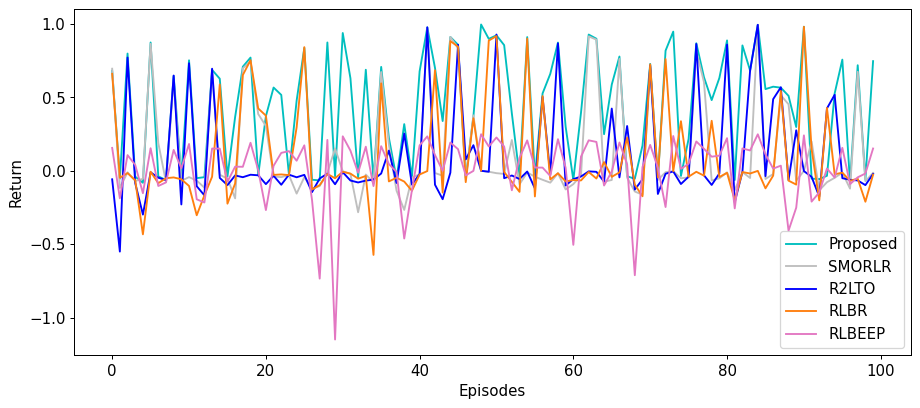

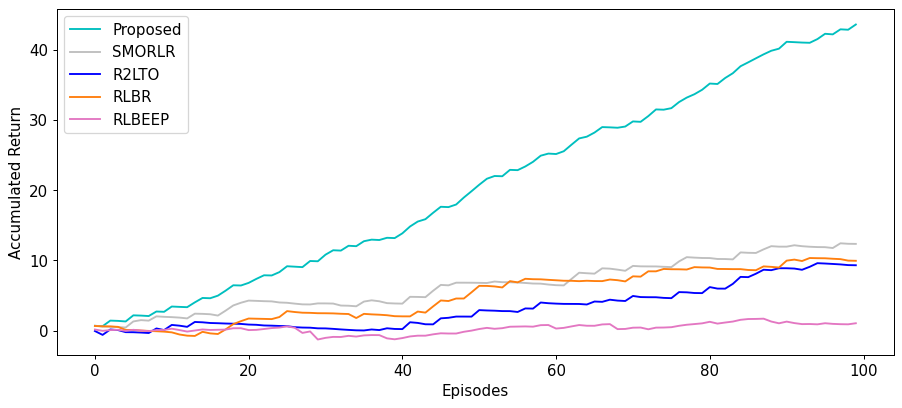

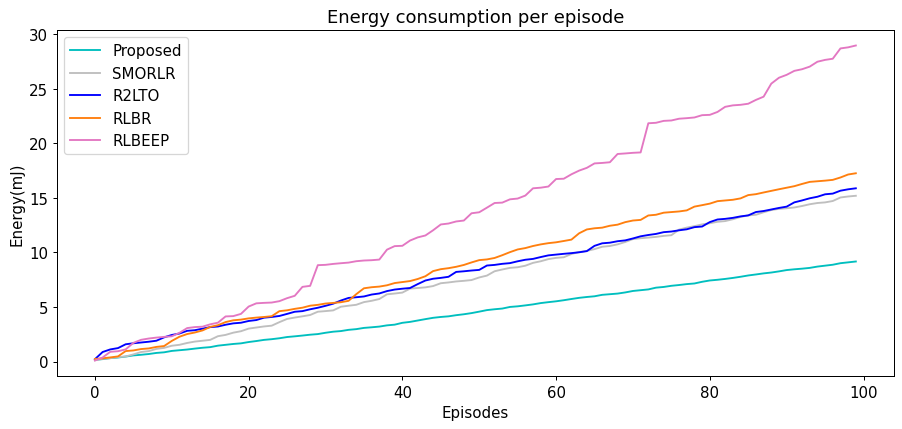

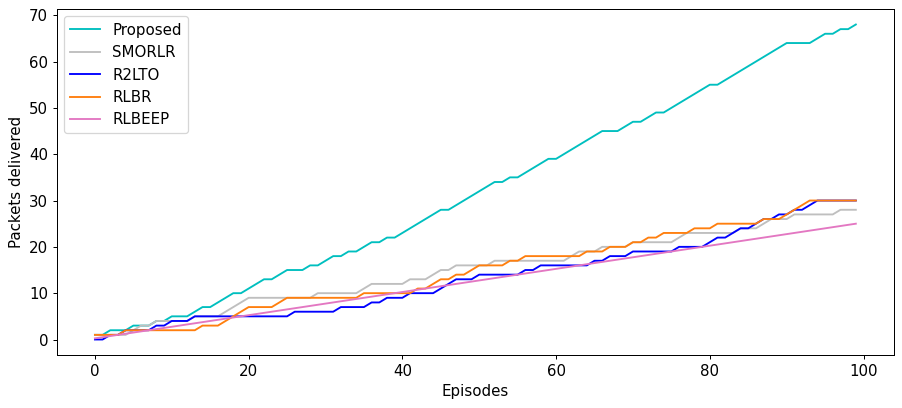

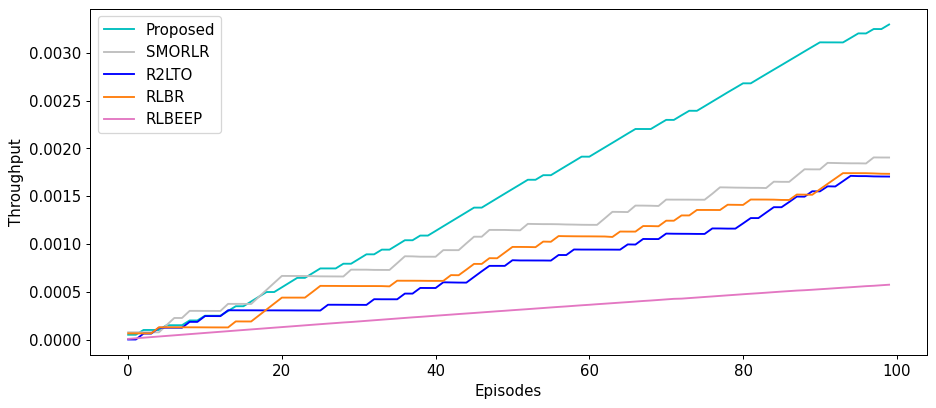

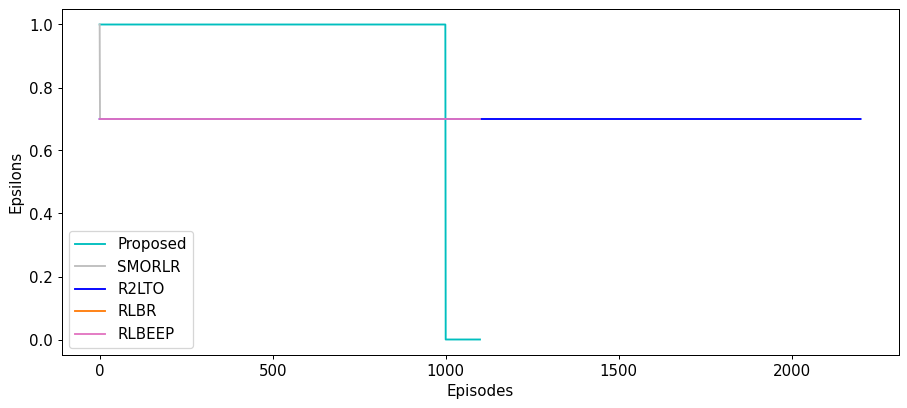

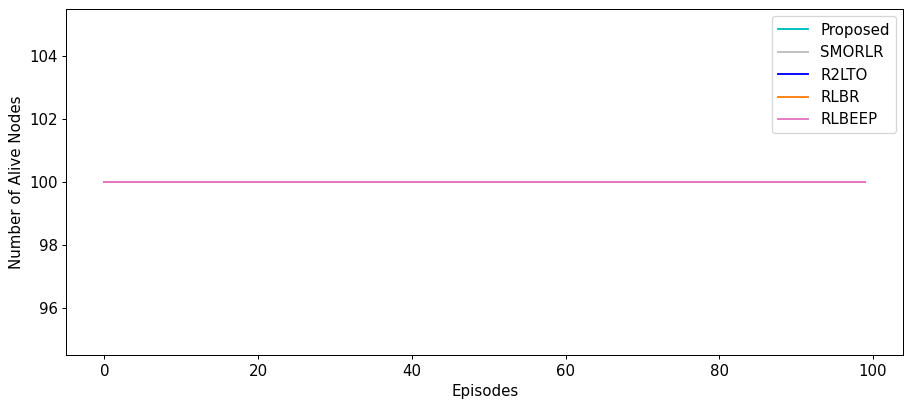

In [14]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(return_proposed)), return_proposed, color='c', label='Proposed')
plt.plot(range(len(return_staticQ)), return_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(return2)), return2, color='b', label='R2LTO')
plt.plot(range(len(return3)), return3, color='tab:orange', label='RLBR')
plt.plot(range(len(return4)), return4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(acc_return_proposed)), acc_return_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_return_staticQ)), acc_return_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_return2)), acc_return2, color='b', label='R2LTO')
plt.plot(range(len(acc_return3)), acc_return3, color='tab:orange', label='RLBR')
plt.plot(range(len(acc_return4)), acc_return4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Accumulated Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()

x2 = range(len(acc_energy_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, energy6, color='r', label='Proposed')
plt.plot(x2, acc_energy_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_energy_staticQ)), acc_energy_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_energy2)), acc_energy2, color='b', label='R2LTO')
plt.plot(range(len(acc_energy3)), acc_energy3, color='tab:orange', label='RLBR')
plt.plot(range(len(acc_energy4)), acc_energy4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_energy_consumption, color='g', label='FMOLD')
# plt.plot(x, RSPAR_energy_consumption, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Energy(mJ)")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.title("Energy consumption per episode")
plt.show()

x = range(len(packets_delivered_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, delivery6, color='r', label='Proposed')
plt.plot(x, packets_delivered_proposed, color='c', label='Proposed')
plt.plot(range(len(packets_delivered_staticQ)), packets_delivered_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(packets_delivered2)), packets_delivered2, color='b', label='R2LTO')
plt.plot(range(len(packets_delivered3)), packets_delivered3, color='tab:orange', label='RLBR')
plt.plot(range(len(packets_delivered4)), packets_delivered4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Packets delivered")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(throughput_proposed)), throughput_proposed, color='c', label='Proposed')
plt.plot(range(len(throughput_staticQ)), throughput_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(throughput2)), throughput2, color='b', label='R2LTO')
plt.plot(range(len(throughput3)), throughput3, color='tab:orange', label='RLBR')
plt.plot(range(len(throughput4)), throughput4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Throughput")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(epsilons_proposed)), epsilons_proposed, color='c', label='Proposed')
plt.plot(range(len(epsilons_staticQ)), epsilons_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(epsilons2)), epsilons2, color='b', label='R2LTO')
plt.plot(range(len(epsilons3)), epsilons3, color='tab:orange', label='RLBR')
plt.plot(range(len(epsilons4)), epsilons4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Epsilons")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot networks' lifetime

x = range(len(alive_node_proposed))
plt.figure(figsize=(12, 5))
plt.plot(x, alive_node_proposed, color='c', label='Proposed')
plt.plot(range(len(alive_node_staticQ)), alive_node_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(alive_node2)), alive_node2, color='b', label='R2LTO')
plt.plot(range(len(alive_node3)), alive_node3, color='tab:orange', label='RLBR')
plt.plot(range(len(alive_node4)), alive_node4, color='tab:pink', label='RLBEEP')
plt.xlabel("Episodes")
plt.ylabel("Number of Alive Nodes")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

####################################       MALICIOUS NODE       ################################################
Episode =  1 , Alive node count =  100 , Package drop count =  1
####################################       MALICIOUS NODE       ################################################
Episode =  2 , Alive node count =  100 , Package drop count =  2
Episode =  3 , Alive node count =  100 , Package drop count =  2
####################################       MALICIOUS NODE       ################################################
Episode =  4 , Alive node count =  100 , Package drop count =  3
####################################       MALICIOUS NODE       ################################################
Episode =  5 , Alive node count =  100 , Package drop count =  4
####################################       MALICIOUS NODE       ################################################
Episode =  6 , Alive node count =  100 , Package drop count =  5
####################################       MA

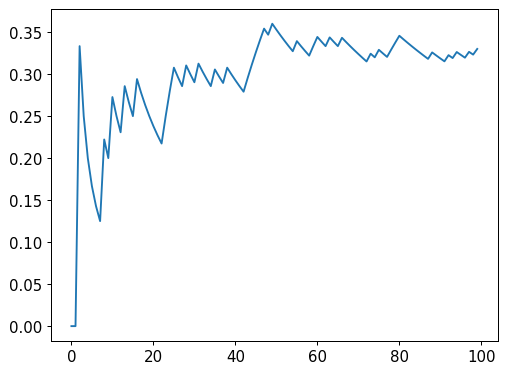

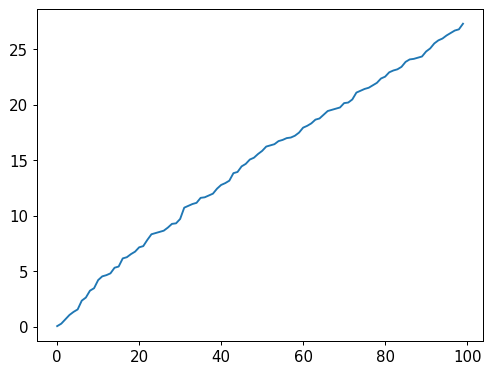

In [15]:
# Fuzzy logic based algorithm implementation
"""
Algorithm based on work done by Minhas et al. (2009)

Minhas, M. R., Gopalakrishnan, S., & Leung, V. C. M. (2009). Multiobjective Routing for Simultaneously Optimizing System Lifetime and Source-to-Sink Delay in Wireless Sensor Networks. 2009 29th IEEE International Conference on Distributed Computing Systems Workshops (p. 123-129). IEEE. 10.1109/ICDCSW.2009.83

"""

import random
import matplotlib.pyplot as plt
import math
import heapq

# edge l = 2m

# Network environment settings
#constants used in energy calculation
# transmission_energy_cost = 45
number_of_episodes = 100

EPISODES = number_of_episodes
PROBABILITY_OF_PACKET_LOST = 1.0 # Blackhole attack

#define the shape of the environment (i.e., its states)
environment_rows = 10
environment_columns = 10

transmission_energy_cost = 0.007    # the amount of energy(mJ) consumed by a node to receive and forward a packet to 1 hop distance
active_mode_energy_cost = 0.0005    #the amount of energy(mj) cosumed by a node for being in active mode
# initial_node_energy = 0.7

num_malicious_rows = 8
fuzzyMaliciousNodes = {} # comment out nodes for different tests
fuzzyMaliciousNodes[(1, 5)] = 0
# fuzzyMaliciousNodes[(1, 3)] = 0
fuzzyMaliciousNodes[(2, 1)] = 0
# fuzzyMaliciousNodes[(2, 6)] = 0
fuzzyMaliciousNodes[(3, 2)] = 0
# fuzzyMaliciousNodes[(3, 5)] = 0
fuzzyMaliciousNodes[(4, 3)] = 0
# fuzzyMaliciousNodes[(4, 6)] = 0
fuzzyMaliciousNodes[(5, 4)] = 0
fuzzyMaliciousNodes[(6, 5)] = 0
# fuzzyMaliciousNodes[(6, 7)] = 0
fuzzyMaliciousNodes[(7, 8)] = 0
# fuzzyMaliciousNodes[(7, 7)] = 0
fuzzyMaliciousNodes[(8, 3)] = 0
# fuzzyMaliciousNodes[(8, 1)] = 0




maliciousNodesKeys = fuzzyMaliciousNodes.keys()

####### No need to change #######################

COLUMNS = 10
ROWS = 10
NUMBER_OF_NODES = COLUMNS * ROWS
RADIO_DIST = 1


fuzzy_delivery_rate = []
fuzzy_energy_consumption = []
fuzzy_total_consumption = []
fuzzy_tot_packets_deliered = []

fuzzy_subepisode_packets_deliered = []
fuzzy_subepisode_packet_delivery_rate = []
fuzzy_subepisode_t_energy = []
fuzzy_subepisode_energy_rate = []

fuzzy_subepisode_tot_packets_deliered = 0
fuzzy_subepisode_tot_energy = 0

fuzzy_subepisode_reward_rate = []
fuzzy_total_reward = 0
fuzzy_subepisode_tot_reward = 0

fuzzy_packets_delivered = 0
package_dropped = 0
sent_packet_count = 0
lifetime = []
path_lenght = 0

fuzzy_alive = []
fuzzy_dead_nodes = []
fuzzy_lifetime = []
fuzzy_alive_node_count = environment_rows * environment_columns

fuzzy_throughput = []
time = 0

#-----SIMULATION SET UP-------

nodes = [] # [(x-coordinate, y-coordinate), ...]

edges = [] # [(from_node, to_node, distance), ...]
# node = (x-coordinate, y-coordinate)

node_to_energy = {} # key = node (x-coordinate, y-coordinate). Value = residual energy of node

node_to_maximum_path = {} # key = node (x-coordinate, y-coordinate). Value = maximum path to sink node


def create_network():

    for y in range(0, 10):
        for x in range(0,10):
            nodes.append((x, y))
            # node_to_energy[(x, y)] = random.uniform(initial_node_energy, ENERGY)
            node_to_energy[(x, y)] = initial_node_energy

create_network()


def create_edges(edges, nodes, max_radio_distance):
    for node_one in nodes:
        for node_two in nodes:

            if node_one != node_two:
                x_dist = (node_two[0] - node_one[0])**2
                y_dist = (node_two[1] - node_one[1])**2
                x_y_diff = x_dist + y_dist
                distance = math.sqrt(x_y_diff)

                if distance <= max_radio_distance:
                    edges.append((node_one, node_two, distance))


create_edges(edges=edges, nodes=nodes, max_radio_distance=RADIO_DIST)

#-----SIMULATION SET UP END-------


def reception_cost():
    return 0 # No cost of reception

#constants used in fuzzy lifetime membership function
ALPHA = 0.2
GAMMA = 0.9
BETA = 0.2
SIGMA = initial_node_energy
THETA = [0.2, 0.8]

# Equation 6, Fuzzy lifetime membership function
def lifetime_membership_eq6(residual_energy):
    current_energy = residual_energy - transmission_energy_cost

    if (ALPHA * SIGMA) < current_energy and current_energy <= SIGMA:
        return 1 - ((1 - GAMMA) / (1 - ALPHA)) * (1 - current_energy / SIGMA)

    elif transmission_energy_cost < current_energy and current_energy <= (ALPHA * SIGMA):

        condition_1 = (GAMMA) / (ALPHA * (SIGMA - transmission_energy_cost))
        condition_2 = current_energy - transmission_energy_cost
        return condition_1 * condition_2

    elif current_energy <= transmission_energy_cost:
        return 0
    else:
        return 1 # Sink node


# Equation 7, fuzzy membership minimun delay
def minimum_delay_eq7(node):
    return 1 + (((THETA[1] - 1) * node_to_maximum_path[node]) / max(node_to_maximum_path.values())) # THETA can change based on test runs


# The network is at risk of not proiritizing lifetime that shortest path sometimes
# Equation 10, mulitobjective membership function
def multi_objective_membership_eq10(umd, ulf):
    return (BETA * min(umd, ulf)) + ((1 - BETA) * ((umd + ulf) / 2))


# Equation 11, returns new value of weight of edge
def weight_assign_eq11(edge):
    residual_energy = node_to_energy[edge[1]]
    return 1 - multi_objective_membership_eq10(lifetime_membership_eq6(residual_energy), minimum_delay_eq7(edge[1]))


def create_source_nodes_list(routes):
    for _ in range(0, EPISODES):

        index = random.randint(0, len(nodes) - 2)
        routes.append(nodes[index])


def get_shortest_path(edge_list, start_node, end_node):

    #dictionairy where key = a node and value is the previous node when calc dijkstras
    path_nodes = {}
    path_nodes[end_node] = None

    distances = {node: float('inf') for node,_,_ in edge_list}
    distances[start_node] = 0

    unvisited_known_nodes = [(0, start_node)]
    heapq.heapify(unvisited_known_nodes)

    while unvisited_known_nodes:

        (curr_dist, curr_node) = heapq.heappop(unvisited_known_nodes)

        #stop if visiting end_node
        if curr_node == end_node:
            break

        for (from_node, to_node, w) in edge_list:
            if from_node == curr_node:
                new_dist = curr_dist + edge_list[(from_node, to_node, w)]

                if new_dist < distances[to_node]:

                    distances[to_node] = new_dist

                    path_nodes[to_node] = from_node
                    heapq.heappush(unvisited_known_nodes, (new_dist, to_node))

    # Creates a list of the nodes between start_node and end_node
    path = []

    node = end_node
    while node != start_node:
        path.append(node)
        #just in case there is no path between nodes the loop stops if the previous value is None

        if path_nodes[node] is not None:
            node = path_nodes[node]
        else:
            break

    path.append(start_node)
    path.reverse()

    return path


# def send_data_and_compute_new_energy(path, fuzzy_total_network_lifetime):
#     global package_dropped
#     # global fuzzy_subepisode_tot_packets_deliered
#     path_lenght = 0
#     packet_delivered_flag = False

#     for index, current_node in enumerate(path):
#         # add one step to path lenght

#         path_lenght += 1
#         fuzzy_total_network_lifetime += 1

#         # if the energy level of any node is zero or less, it means that the node is died
#         for node in node_to_energy:
#             if node_to_energy[node] <= 0:
#                 lifetime.append(fuzzy_total_network_lifetime)

#         for node in node_to_energy: # Remove energy from all nodes.
#             node_to_energy[node] = node_to_energy[node] - active_mode_energy_cost

#         if index == len(path) - 1:
#             packet_delivered_flag = True
#             return fuzzy_total_network_lifetime, packet_delivered_flag

#         if current_node in maliciousNodesKeys:
#             # Blackhole Attack
#             package_dropped = package_dropped + 1
#             return fuzzy_total_network_lifetime, packet_delivered_flag

#             # Selective Forwarding Attack
#             # if random.random() < PROBABILITY_OF_PACKET_LOST:
#             #     package_dropped = package_dropped + 1
#             #     return fuzzy_total_network_lifetime


#         current_energy = node_to_energy[current_node]

#         if index == 0:
#             # Do Only transmission on first node
#             node_to_energy[current_node] = current_energy - transmission_energy_cost
#             continue

#         # Send data
#         node_to_energy[current_node] = current_energy - transmission_energy_cost - reception_cost()
#     return fuzzy_total_network_lifetime, packet_delivered_flag


def send_data_and_compute_new_energy(path, fuzzy_total_network_lifetime, fuzzy_alive_node_count, fuzzy_dead_nodes, fuzzy_lifetime, package_dropped, time):
    # global package_dropped
    # global fuzzy_subepisode_tot_packets_deliered
    path_lenght = 0
    packet_delivered_flag = False

    for index, current_node in enumerate(path):
        # add one step to path lenght

        path_lenght += 1
        fuzzy_total_network_lifetime += 1
        time += 1

        # if the energy level of any node is zero or less, it means that the node is died
        for node in node_to_energy:
            if node_to_energy[node] <= 0 and node not in fuzzy_dead_nodes:
                fuzzy_lifetime.append(fuzzy_total_network_lifetime)
                fuzzy_dead_nodes.append(node)
                fuzzy_alive_node_count -= 1

        for node in node_to_energy: # Remove energy from all nodes.
            node_to_energy[node] = node_to_energy[node] - active_mode_energy_cost


        if index == len(path) - 1:
            packet_delivered_flag = True
            return fuzzy_total_network_lifetime, packet_delivered_flag, fuzzy_alive_node_count,  fuzzy_dead_nodes, fuzzy_lifetime, package_dropped, time


        if current_node in maliciousNodesKeys:
            # Blackhole Attack
            package_dropped = package_dropped + 1
            packet_delivered_flag = False
            # node_to_energy[current_node] = node_to_energy[current_node] - transmission_energy_cost - reception_cost()
            print("####################################       MALICIOUS NODE       ################################################")
            return fuzzy_total_network_lifetime, packet_delivered_flag, fuzzy_alive_node_count,  fuzzy_dead_nodes, fuzzy_lifetime, package_dropped, time
            # if random.random() < PROBABILITY_OF_PACKET_LOST:
            #     package_dropped = package_dropped + 1
            #     return fuzzy_total_network_lifetime

        if index == 0:
            # Do Only transmission on first node
            node_to_energy[current_node] = node_to_energy[current_node] - transmission_energy_cost
            continue


        # current_energy = node_to_energy[current_node]

        # # Send data
        node_to_energy[current_node] = node_to_energy[current_node] - transmission_energy_cost - reception_cost()
    return fuzzy_total_network_lifetime, packet_delivered_flag, fuzzy_alive_node_count,  fuzzy_dead_nodes, fuzzy_lifetime, package_dropped, time


def shortest_distance_to_sink(edge_list, start_node, end_node):
    distances = {node: float('inf') for node,_,_ in edge_list}
    distances[start_node] = 0

    unvisited_known_nodes = [(0, start_node)]
    heapq.heapify(unvisited_known_nodes)

    while unvisited_known_nodes: # change name

        (curr_dist, curr_node) = heapq.heappop(unvisited_known_nodes)

        #stop if visiting end_node
        if curr_node == end_node:
            break

        for (from_node, to_node, w) in edge_list:
            if from_node == curr_node:
                new_dist = curr_dist + w

                if new_dist < distances[to_node]:

                    distances[to_node] = new_dist
                    heapq.heappush(unvisited_known_nodes, (new_dist, to_node))

    return distances[end_node]


def calculate_distances_to_sink(end_node_input):
    for node in nodes:
        node_to_maximum_path[node] = shortest_distance_to_sink(edge_list=edges, start_node=node, end_node=end_node_input)


def generate_sink_node():
    # ix = random.randint(0, NUMBER_OF_NODES - 1)
    return nodes[NUMBER_OF_NODES - 1]

def calculate_energy_consumption():
    energy_left = sum(node_to_energy.values())
    return (initial_node_energy * NUMBER_OF_NODES) - energy_left


def main():
    #dict with edge - weight in this context
    edge_weight = {} # Key = edge, value = weight

    # Initialize routing requests
    routing_request = []
    create_source_nodes_list(routing_request)

    global sent_packet_count
    global fuzzy_total_network_lifetime
    global fuzzy_alive_node_count
    global fuzzy_alive
    global fuzzy_dead_nodes
    global fuzzy_lifetime
    global fuzzy_subepisode_tot_energy
    global fuzzy_tot_energy
    global fuzzy_subepisode_tot_energy
    global fuzzy_subepisode_tot_packets_deliered
    global fuzzy_subepisode_tot_reward
    global fuzzy_throughput
    global time
    global fuzzy_returns
    global fuzzy_tot_return
    global fuzzy_packets_delivered

    fuzzy_total_network_lifetime = 0
    fuzzy_packets_delivered = []
    fuzzy_alive_node_count = environment_rows * environment_columns
    fuzzy_dead_nodes = []
    fuzzy_lifetime = []
    fuzzy_alive = []
    fuzzy_throughput = []
    fuzzy_returns = []
    fuzzy_tot_return = []
    tot_return = 0
    tot_packets_delivered = 0
    package_dropped = 0
    time = 0

    # ix = 0 # Counter for terminal window

    fuzzy_subepisode_tot_packets_deliered = 0
    fuzzy_subepisode_tot_energy = 0
    fuzzy_tot_energy = 0
    energy_left = sum(node_to_energy.values())

    for request in routing_request: # Iterate for different source nodes
        sent_packet_count = sent_packet_count + 1
        episode = sent_packet_count
        delivery_reward = 0
        # energy_left = sum(node_to_energy.values())

        b=episode_preferences[episode-1]
        if episode % duration_testing_subepisode == 0:
          fuzzy_subepisode_tot_packets_deliered = 0
          fuzzy_subepisode_tot_energy = 0
          fuzzy_subepisode_tot_reward = 0

        sink_node = generate_sink_node()

        calculate_distances_to_sink(sink_node)

        for _, edge in enumerate(edges):

            #assign weight to edges and add to dict
            edge_weight[edge] = weight_assign_eq11(edge)

        minimum_weight_path = get_shortest_path(edge_weight, request, sink_node)
        subepisode_number = (sent_packet_count)%duration_testing_subepisode

        if len(minimum_weight_path) == 1:
            time += 1
            delivery_reward = 1
            prev_subepisode_energy_left = energy_left
            energy_left = sum(node_to_energy.values())
            energy = prev_subepisode_energy_left - energy_left

            fuzzy_delivery_rate.append((sent_packet_count - package_dropped) / sent_packet_count)
            fuzzy_tot_packets_deliered.append((sent_packet_count - package_dropped))
            fuzzy_energy_consumption.append(energy)

            # fuzzy_subepisode_tot_packets_deliered += sent_packet_count - package_dropped
            fuzzy_subepisode_tot_energy += energy
            fuzzy_tot_energy += energy
            tot_return += (1-b)*delivery_reward - b*energy
            fuzzy_returns.append((1-b)*delivery_reward - b*energy)
            fuzzy_tot_return.append(tot_return)
            # subepisode_number = (sent_packet_count)%duration_testing_subepisode
            fuzzy_subepisode_packet_delivery_rate.append(fuzzy_subepisode_tot_packets_deliered/(subepisode_number+1))
            fuzzy_subepisode_energy_rate.append(fuzzy_subepisode_tot_energy/(subepisode_number+1))
            fuzzy_subepisode_tot_reward += (1-b)*delivery_reward - b*energy
            fuzzy_subepisode_reward_rate.append(fuzzy_subepisode_tot_reward/(subepisode_number+1))
            continue
        else:
            fuzzy_total_network_lifetime, packet_delivered_flag, fuzzy_alive_node_count,  fuzzy_dead_nodes, fuzzy_lifetime, package_dropped, time = send_data_and_compute_new_energy(minimum_weight_path, fuzzy_total_network_lifetime, fuzzy_alive_node_count, fuzzy_dead_nodes, fuzzy_lifetime, package_dropped, time)
            prev_subepisode_energy_left = energy_left
            energy_left = sum(node_to_energy.values())
            energy = prev_subepisode_energy_left - energy_left

        # prev_subepisode_energy_left = energy_left
        # energy_left = sum(node_to_energy.values())
        # energy = prev_subepisode_energy_left - energy_left

        fuzzy_alive.append(fuzzy_alive_node_count)
        print("Episode = ", episode, ", Alive node count = ", fuzzy_alive_node_count, ", Package drop count = ", package_dropped)

        if packet_delivered_flag==True:
          fuzzy_subepisode_tot_packets_deliered += 1
          tot_packets_delivered += 1
          fuzzy_packets_delivered.append(tot_packets_delivered)
          delivery_reward = 1
        else:
          fuzzy_packets_delivered.append(tot_packets_delivered)
          delivery_reward = 0

        fuzzy_delivery_rate.append((sent_packet_count - package_dropped) / sent_packet_count)
        fuzzy_tot_packets_deliered.append((sent_packet_count - package_dropped))
        # fuzzy_energy_consumption.append(energy)

        fuzzy_subepisode_tot_energy += energy
        fuzzy_tot_energy += energy
        fuzzy_energy_consumption.append(fuzzy_tot_energy)
        fuzzy_subepisode_energy_rate.append(fuzzy_subepisode_tot_energy/(subepisode_number+1))
        fuzzy_subepisode_packet_delivery_rate.append(fuzzy_subepisode_tot_packets_deliered/(subepisode_number+1))
        fuzzy_subepisode_tot_reward += (1-b)*delivery_reward - b*energy
        tot_return += (1-b)*delivery_reward - b*energy
        fuzzy_returns.append((1-b)*delivery_reward - b*energy)
        fuzzy_tot_return.append(tot_return)
        fuzzy_subepisode_reward_rate.append(fuzzy_subepisode_tot_reward/(subepisode_number+1))
        fuzzy_throughput.append((sent_packet_count - package_dropped)/time)

        # for node in node_to_energy:
        #     if node_to_energy[node] <= 0:
        #         return sent_packet_count
        if sent_packet_count == number_of_episodes:
          if len(fuzzy_lifetime) == 0:
            fuzzy_lifetime.append(fuzzy_total_network_lifetime)
          print("Network Lifetime = ", fuzzy_lifetime[0])
          return sent_packet_count

    if len(fuzzy_lifetime) == 0:
      fuzzy_lifetime.append(fuzzy_total_network_lifetime)
    print("Network Lifetime = ", fuzzy_lifetime[0])
    return sent_packet_count



if __name__ == '__main__':

    global fuzzy_packets_sent
    global fuzzy_packets_delivered
    global fuzzy_packets_dropped
    global fuzzy_total_energy_consumed
    global fuzzy_energy_efficiency
    global fuzzy_tot_return
    global fuzzy_returns
    # global fuzzy_lifetime

    fuzzy_packets_sent = main()
    # fuzzy_packets_delivered = sent_packet_count - package_dropped
    # fuzzy_total_energy_consumed = calculate_energy_consumption()
    # fuzzy_energy_efficiency = (sent_packet_count - package_dropped) / calculate_energy_consumption()
    # if len(lifetime) == 0:
    #   lifetime.append(fuzzy_total_network_lifetime)

    # if len(lifetime) == 0:
    #   lifetime.append(fuzzy_total_network_lifetime)
    # fuzzy_lifetime = lifetime[0]

    # print('Fuzzy Training complete!')
    # print("Packages sent: ", fuzzy_packets_sent)
    # print("Packages delivered: ", fuzzy_packets_delivered)
    # print("Delivery rate: ", fuzzy_packets_delivered / EPISODES)
    # print("Dropped packages: ", package_dropped)
    # print("Energy consumption: ", calculate_energy_consumption())
    # print("Energy efficiency: ", (sent_packet_count - package_dropped) / calculate_energy_consumption())
    # print("Network Lifetime: ", fuzzy_lifetime)


    life = []
    for x in range(0, sent_packet_count):
        life.append(x)

    print("NODES")
    for i, node in enumerate(node_to_energy):
        print(node, node_to_energy[node])

    # Uncomment to see plots

    # DELIVERY RATE
    plt.plot(life, fuzzy_delivery_rate)
    plt.show()

    # ENERGY CONSUMPTION
    plt.plot(life, fuzzy_energy_consumption)
    plt.show()



# packet_delivery , t_energy, alive_node = Thesis_approach()
# delivery , energy, alive_node3 = R2LTO()
# delivery2 , energy2, alive_node4 = RLBR()

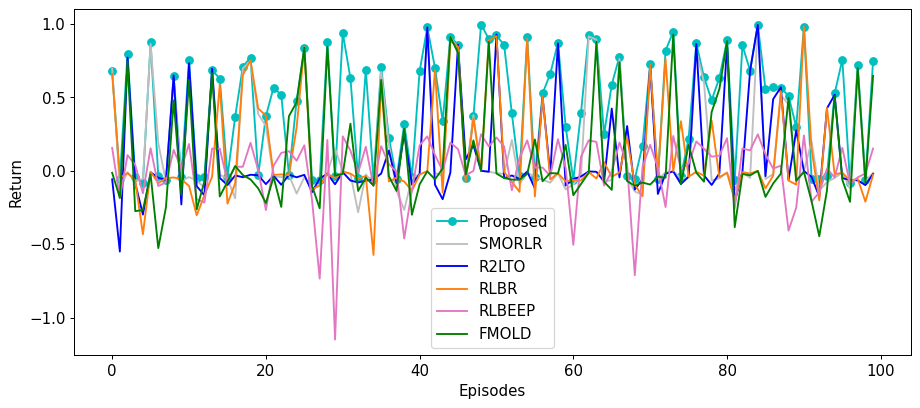

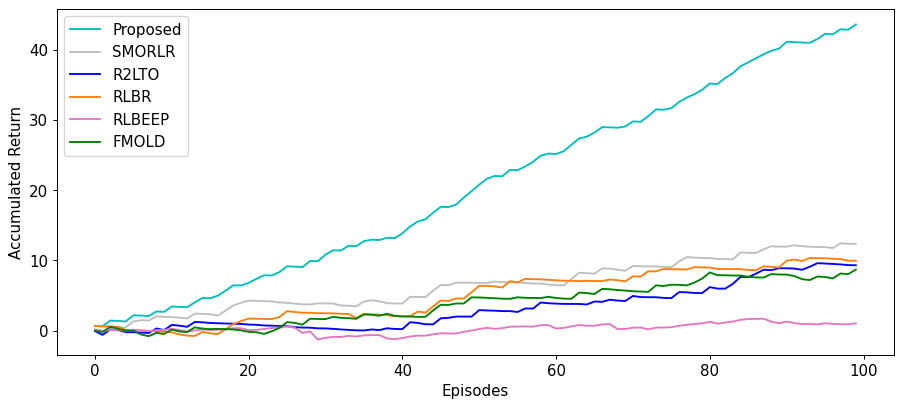

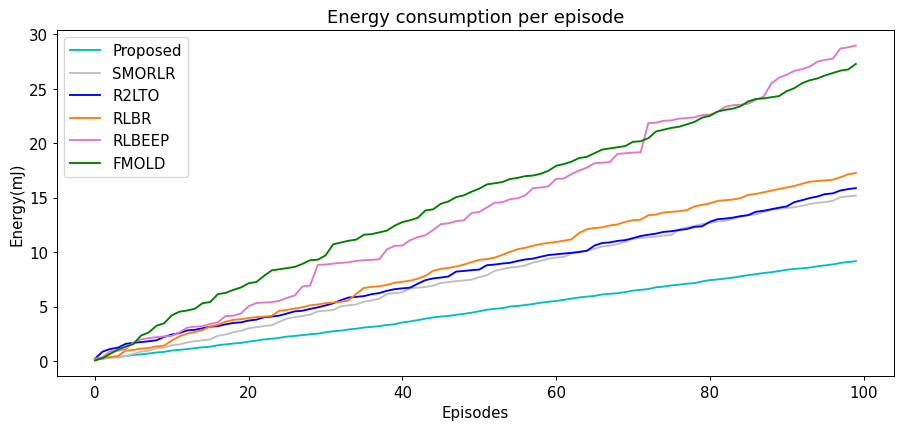

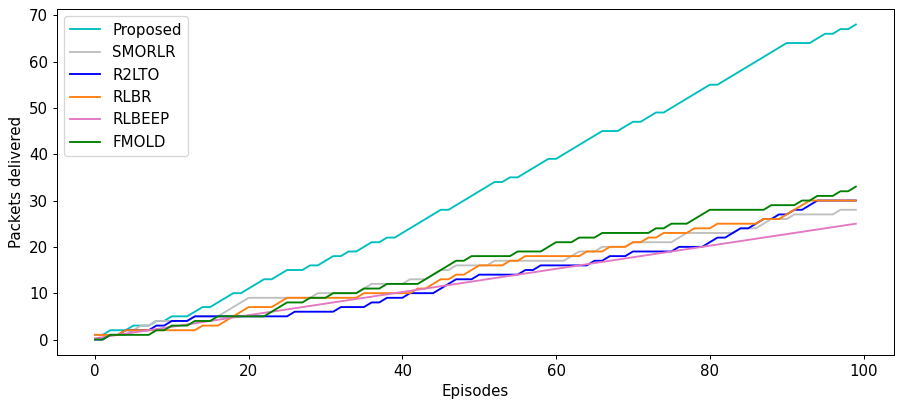

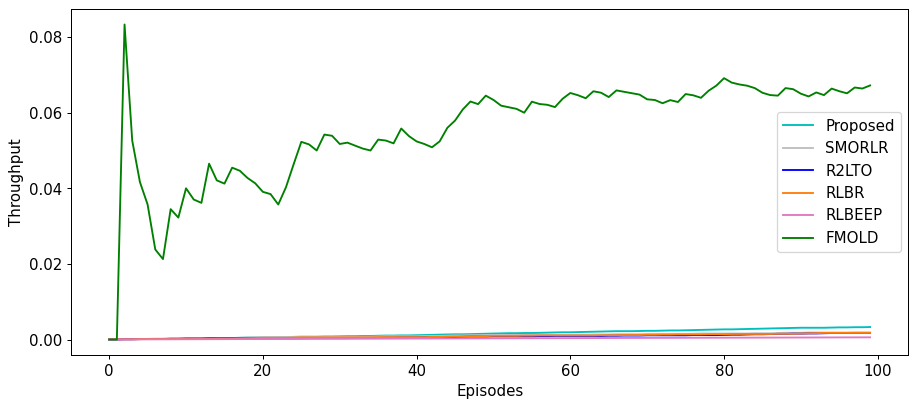

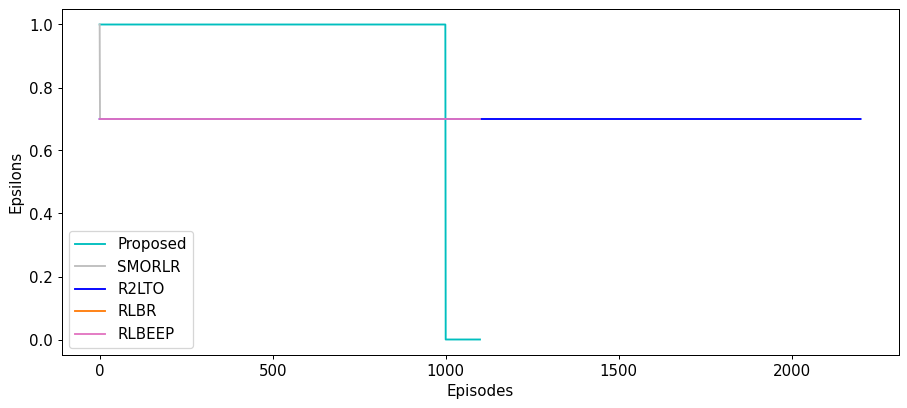

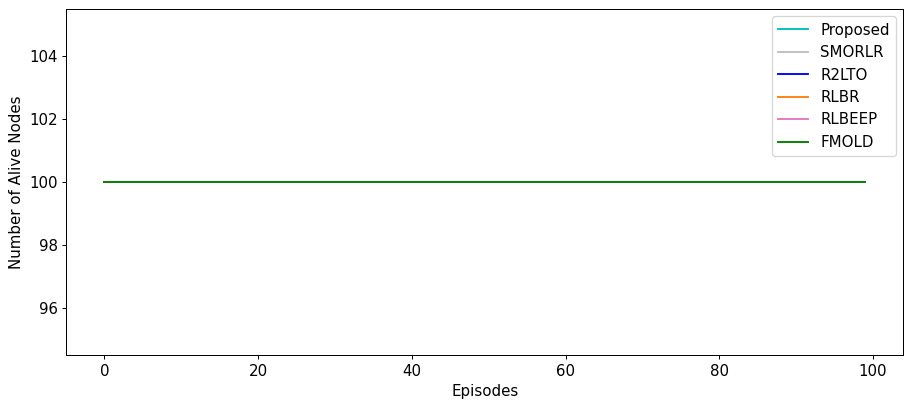

In [16]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(return_proposed)), return_proposed, color='c', marker = 'o', label='Proposed')
plt.plot(range(len(return_staticQ)), return_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(return2)), return2, color='b', label='R2LTO')
plt.plot(range(len(return3)), return3, color='tab:orange', label='RLBR')
plt.plot(range(len(return4)), return4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_returns)), fuzzy_returns, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(acc_return_proposed)), acc_return_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_return_staticQ)), acc_return_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_return2)), acc_return2, color='b', label='R2LTO')
plt.plot(range(len(acc_return3)), acc_return3, color='tab:orange', label='RLBR')
plt.plot(range(len(acc_return4)), acc_return4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_tot_return)), fuzzy_tot_return, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Accumulated Return")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()

x2 = range(len(acc_energy_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, energy6, color='r', label='Proposed')
plt.plot(x2, acc_energy_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_energy_staticQ)), acc_energy_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_energy2)), acc_energy2, color='b', label='R2LTO')
plt.plot(range(len(acc_energy3)), acc_energy3, color='tab:orange', label='RLBR')
plt.plot(range(len(acc_energy4)), acc_energy4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_energy_consumption)), fuzzy_energy_consumption, color='g', label='FMOLD')
# plt.plot(x, RSPAR_energy_consumption, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Energy(mJ)")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.title("Energy consumption per episode")
plt.show()

x = range(len(packets_delivered_proposed))
plt.figure(figsize=(12, 5))
# plt.plot(x, delivery6, color='r', label='Proposed')
plt.plot(x, packets_delivered_proposed, color='c', label='Proposed')
plt.plot(range(len(packets_delivered_staticQ)), packets_delivered_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(packets_delivered2)), packets_delivered2, color='b', label='R2LTO')
plt.plot(range(len(packets_delivered3)), packets_delivered3, color='tab:orange', label='RLBR')
plt.plot(range(len(packets_delivered4)), packets_delivered4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_packets_delivered)), fuzzy_packets_delivered, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Packets delivered")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(range(len(throughput_proposed)), throughput_proposed, color='c', label='Proposed')
plt.plot(range(len(throughput_staticQ)), throughput_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(throughput2)), throughput2, color='b', label='R2LTO')
plt.plot(range(len(throughput3)), throughput3, color='tab:orange', label='RLBR')
plt.plot(range(len(throughput4)), throughput4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_throughput)), fuzzy_throughput, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Throughput")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(len(epsilons_proposed)), epsilons_proposed, color='c', label='Proposed')
plt.plot(range(len(epsilons_staticQ)), epsilons_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(epsilons2)), epsilons2, color='b', label='R2LTO')
plt.plot(range(len(epsilons3)), epsilons3, color='tab:orange', label='RLBR')
plt.plot(range(len(epsilons4)), epsilons4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Epsilons")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()


# Plot networks' lifetime

x = range(len(alive_node_proposed))
plt.figure(figsize=(12, 5))
plt.plot(x, alive_node_proposed, color='c', label='Proposed')
plt.plot(range(len(alive_node_staticQ)), alive_node_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(alive_node2)), alive_node2, color='b', label='R2LTO')
plt.plot(range(len(alive_node3)), alive_node3, color='tab:orange', label='RLBR')
plt.plot(range(len(alive_node4)), alive_node4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_alive)), fuzzy_alive, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes")
plt.ylabel("Number of Alive Nodes")
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

start energy for nodes: 
(x, y): (0, 0)   25.0
(x, y): (0, 1)   25.0
(x, y): (0, 2)   25.0
(x, y): (0, 3)   25.0
(x, y): (0, 4)   25.0
(x, y): (0, 5)   25.0
(x, y): (0, 6)   25.0
(x, y): (0, 7)   25.0
(x, y): (0, 8)   25.0
(x, y): (0, 9)   25.0
(x, y): (1, 0)   25.0
(x, y): (1, 1)   25.0
(x, y): (1, 2)   25.0
(x, y): (1, 3)   25.0
(x, y): (1, 4)   25.0
(x, y): (1, 5)   25.0
(x, y): (1, 6)   25.0
(x, y): (1, 7)   25.0
(x, y): (1, 8)   25.0
(x, y): (1, 9)   25.0
(x, y): (2, 0)   25.0
(x, y): (2, 1)   25.0
(x, y): (2, 2)   25.0
(x, y): (2, 3)   25.0
(x, y): (2, 4)   25.0
(x, y): (2, 5)   25.0
(x, y): (2, 6)   25.0
(x, y): (2, 7)   25.0
(x, y): (2, 8)   25.0
(x, y): (2, 9)   25.0
(x, y): (3, 0)   25.0
(x, y): (3, 1)   25.0
(x, y): (3, 2)   25.0
(x, y): (3, 3)   25.0
(x, y): (3, 4)   25.0
(x, y): (3, 5)   25.0
(x, y): (3, 6)   25.0
(x, y): (3, 7)   25.0
(x, y): (3, 8)   25.0
(x, y): (3, 9)   25.0
(x, y): (4, 0)   25.0
(x, y): (4, 1)   25.0
(x, y): (4, 2)   25.0
(x, y): (4, 3)   25.0
(x, y):

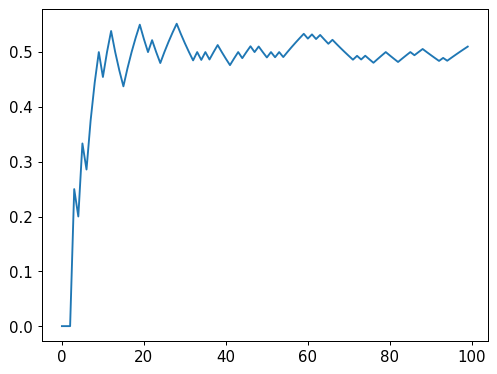

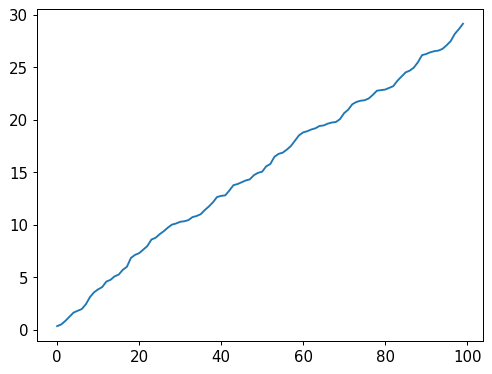

In [17]:
"""
Algorithm based on work done by Cota-Ruiz et al. (2016).

Cota-Ruiz, J., Rivas-Perea, P., Sifuentes, E., & Gonzalez-Landaeta, R. (2016). A recursive shortest path routing algorithm with application for wireless sensor network localization. IEEE Sensors Journal, 16(11), 4631-4637. https://doi.org/10.1109/JSEN.2016.2543680.

"""

import copy
import random
import matplotlib.pyplot as plt

environment_rows = 10
environment_columns = 10

NUMBER_OF_NODES = environment_columns * environment_rows

NUMBER_OF_EPISODES = 100
transmission_energy_cost = 0.007    # the amount of energy(mJ) consumed by a node to receive and forward a packet to 1 hop distance
active_mode_energy_cost = 0.0005    #the amount of energy(mj) cosumed by a node for being in active mode
MAX_RADIO_DISTANCE = 1

# lifetime = 0
RSPAR_tot_packets_deliered = []
RSPAR_tot_energy = 0
RSPAR_delivery_rate = []
RSPAR_energy_consumption = []
RSPAR_total_consumption = []

RSPAR_subepisode_packets_deliered = []
RSPAR_subepisode_packet_delivery_rate = []
RSPAR_subepisode_t_energy = []
RSPAR_subepisode_energy_rate = []

RSPAR_subepisode_tot_packets_deliered = 0
RSPAR_subepisode_tot_energy = 0

RSPAR_subepisode_reward_rate = []
RSPAR_total_reward = 0
RSPAR_subepisode_tot_reward = 0

RSPAR_returns = []
RSPAR_tot_return = []
tot_return = 0

package_dropped = 0
sent_packet_count = 0
lifetime = []
path_lenght = 0

RSPAR_total_network_lifetime = 0
RSPAR_alive_node_count = environment_rows * environment_columns
RSPAR_dead_nodes = []
RSPAR_lifetime = []
RSPAR_alive = []
RSPAR_package_dropped = 0

num_malicious_rows = 8



nodes_dictionairy = {} #Tuple coordinate (x, y) is key, full node is value
node_to_energy = {}


class Node:

    def __init__(self, pos_x, pos_y):
        self.x = pos_x
        self.y = pos_y
        self.neighbors = []
        self.energy = initial_node_energy
        self.rank = 0

    def set_energy(self, energy):
        self.energy = energy

    def add_neighbor(self, new_neighbor):
        if new_neighbor not in self.neighbors:
            self.neighbors.append(new_neighbor)

    def get_neighbors(self):
        return self.neighbors

    def get_position(self):
        return (self.x, self.y)

    def __eq__(self, other):
        if isinstance(other, Node):
            return (self.x, self.y) == (other.x, other.y)
        return NotImplemented

    def __hash__(self):
        return hash(repr(self))

    def __str__(self):
        return "(x, y): {}".format((self.x, self.y))

    def __repr__(self):
        return "(x, y): {}".format((self.x, self.y))

    def print_node(self):
        print("(x, y): {} \nenergy: {} \nrank: {}".format((self.x, self.y), self.energy, self.rank))
        neighbor_string = "Neighbors:"
        for neighbor in self.neighbors:
            neighbor_string += (" " + str(neighbor.get_position()))
        print(neighbor_string)
        print()

fuzzyMaliciousNodes = {} # comment out nodes for different tests
fuzzyMaliciousNodes[(1, 5)] = 0
# fuzzyMaliciousNodes[(1, 3)] = 0
fuzzyMaliciousNodes[(2, 1)] = 0
# fuzzyMaliciousNodes[(2, 6)] = 0
fuzzyMaliciousNodes[(3, 2)] = 0
# fuzzyMaliciousNodes[(3, 5)] = 0
fuzzyMaliciousNodes[(4, 3)] = 0
# fuzzyMaliciousNodes[(4, 6)] = 0
fuzzyMaliciousNodes[(5, 4)] = 0
fuzzyMaliciousNodes[(6, 5)] = 0
# fuzzyMaliciousNodes[(6, 7)] = 0
fuzzyMaliciousNodes[(7, 8)] = 0
# fuzzyMaliciousNodes[(7, 7)] = 0
fuzzyMaliciousNodes[(8, 3)] = 0
# fuzzyMaliciousNodes[(8, 1)] = 0

malicoius_nodes = fuzzyMaliciousNodes.keys()

def create_nodes():
    for x in range(environment_rows):
        for y in range(environment_columns):
            node = Node(x, y)
            # init node energy for all created nodes in node list
            node_to_energy[node] = initial_node_energy
            nodes_dictionairy[(x, y)] = node


def make_neighbors():
    for x in range(environment_rows):
        for y in range(environment_columns):

            if x > 0:
                nodes_dictionairy[(x, y)].add_neighbor(nodes_dictionairy[((x - 1), y)])
            if x < environment_rows - 1:
                nodes_dictionairy[(x, y)].add_neighbor(nodes_dictionairy[((x + 1), y)])
            if y > 0:
                nodes_dictionairy[(x, y)].add_neighbor(nodes_dictionairy[(x, (y - 1))])
            if y < environment_columns - 1:
                nodes_dictionairy[(x, y)].add_neighbor(nodes_dictionairy[(x, (y + 1))])

# STATIC
seq = []

def get_number_of_hops(source_node, hops):
    global c
    global seq

    neighbors = source_node.get_neighbors()

    for index, node in enumerate(neighbors):

        if hops[neighbors[index]] == 0:
            hops[neighbors[index]] = hops[source_node] + 1

        elif (hops[neighbors[index]] - hops[source_node]) <= 1:
            continue

        elif hops[neighbors[index]] < (hops[source_node] - 1):
            hops[source_node] = hops[neighbors[index]] + 1

        else:
            hops[neighbors[index]] = hops[source_node] + 1

            if (max_of_hops(neighbors=neighbors, hops=hops)[1] - hops[neighbors[index]]) > 1:

                get_number_of_hops(neighbors[index], hops)

    if source_node in seq:
        return

    else:
        seq.append(source_node)

    for index, node in enumerate(neighbors):
        get_number_of_hops(neighbors[index], hops)


shortest_path = []


def get_shortest_paths(hops, neighbors, hop_number, paths, sink_node, org_sink):
    global shortest_path
    hop_number -= 1

    for i in range(hop_number + 1):
        for index, node in enumerate(neighbors):

            if hops[neighbors[index]] == (hop_number - i):

                paths[hop_number - i] = neighbors[index]

                get_shortest_paths(hops, node.get_neighbors(), hop_number - i, paths, node, org_sink)

            if (hop_number - i) == 1 and i == 0:
                temp_paths = [node for node in paths if node != None]


                if len(temp_paths) == hops[org_sink]:
                    shortest_path.append(temp_paths)


# returns distance of neighbor with max distance from source node
def max_of_hops(neighbors, hops):
    max_distance = 0
    neighbor_list = []

    for neighbor in neighbors:
        neighbor_of_neigbhors = neighbor.get_neighbors()

        for neighbor_two in neighbor_of_neigbhors:

            if neighbor_two not in neighbor_list:
                neighbor_list.append(neighbor_two)

            if max_distance < hops[neighbor_two]:
                max_distance = hops[neighbor_two]

    return (neighbor_list, max_distance)


def __init__():
    create_nodes()
    make_neighbors()


def find_shortest_path(sink_node, source_node):
    global shortest_path
    global seq

    shortest_path = []
    seq = []

    hops = {x: 0 for x in copy.deepcopy(list(nodes_dictionairy.values()))}

    get_number_of_hops(nodes_dictionairy[source_node], hops)
    hops[nodes_dictionairy[source_node]] = 0

    p = [None] * (hops[sink_node])
    get_shortest_paths(hops, sink_node.get_neighbors(), hops[sink_node], p, sink_node, sink_node)


def print_shortest_path(shortest_path):
    for x in shortest_path:
        for y in x:
            print(y)

        print("--")


def create_grid(rows, columns, nodes, hop):
    grid = [[0]*columns for _ in range(rows)]

    for i in range(rows):
        for j in range(columns):

            if (i, j) in nodes:
                node = nodes_dictionairy[(i, j)]
                grid[i][j] = hop[node]

    return(grid)


def send_data_along_path(path, total_lifetime, RSPAR_alive_node_count, RSPAR_dead_nodes, RSPAR_lifetime, RSPAR_package_dropped, time):
    global lifetime
    # global package_dropped
    packet_delivered_flag = False

    for node in path:
            # print(node)
            # print(malicoius_nodes)
            time += 1
            total_lifetime += 1

            # check_for_dead_nodes(total_lifetime)
            drain_active_energy_off_nodes()

            # lifetime.append(total_lifetime)
            # lifetime += 1
            if (node.x, node.y) in malicoius_nodes:
                RSPAR_package_dropped += 1
                print("############################################  PACKAGE DROPPED   #####################################################")
                return total_lifetime, packet_delivered_flag, RSPAR_alive_node_count,  RSPAR_dead_nodes, RSPAR_lifetime, RSPAR_package_dropped, time

            node_to_energy[node] -= transmission_energy_cost

            # if the energy level of any node is zero or less, it means that the node is died
            for node in node_to_energy:
                if node_to_energy[node] <= 0 and node not in RSPAR_dead_nodes:
                    RSPAR_lifetime.append(RSPAR_total_network_lifetime)
                    RSPAR_dead_nodes.append(node)
                    RSPAR_alive_node_count -= 1
    packet_delivered_flag = True

    return total_lifetime, packet_delivered_flag, RSPAR_alive_node_count,  RSPAR_dead_nodes, RSPAR_lifetime, RSPAR_package_dropped, time


# def check_for_dead_nodes(total_lifetime):
#     for node in node_to_energy:
#             if node_to_energy[node] <= 0:
#                 lifetime.append(total_lifetime)


def drain_active_energy_off_nodes():
    for node in node_to_energy:
        node_to_energy[node] -= active_mode_energy_cost


def calculate_energy_consumption():
    energy_left = sum(node_to_energy.values())
    return (initial_node_energy * NUMBER_OF_NODES) - energy_left


def main():
    global shortest_path
    global recursive_total_lifetime
    global sent_packet_count
    global RSPAR_subepisode_tot_energy
    global RSPAR_subepisode_tot_packets_deliered
    global RSPAR_subepisode_tot_reward
    global RSPAR_total_network_lifetime
    global RSPAR_alive_node_count
    global RSPAR_alive
    global RSPAR_dead_nodes
    global RSPAR_lifetime
    global RSPAR_tot_energy
    global RSPAR_throughput
    global RSPAR_returns
    global RSPAR_tot_return
    global tot_return
    global RSPAR_packets_delivered
    global time

    RSPAR_total_network_lifetime = 0
    RSPAR_alive_node_count = environment_rows * environment_columns
    RSPAR_dead_nodes = []
    RSPAR_lifetime = []
    RSPAR_alive = []
    RSPAR_package_dropped = 0
    RSPAR_tot_energy = 0
    RSPAR_throughput = []
    tot_packets_delivered = 0
    RSPAR_packets_delivered = []
    time = 0

    recursive_total_lifetime = 0
    __init__()

    sink_node = nodes_dictionairy[(9, 9)]

    print("start energy for nodes: ")
    for node in node_to_energy:
        print(node, " ", node_to_energy[node])

    for x in range(0, NUMBER_OF_EPISODES):
        energy_left = sum(node_to_energy.values())
        sent_packet_count = sent_packet_count + 1
        episode = sent_packet_count
        delivery_reward = 0
        # energy_left = sum(node_to_energy.values())

        b=episode_preferences[episode-1]
        if episode % duration_testing_subepisode == 0:
          RSPAR_subepisode_tot_packets_deliered = 0
          RSPAR_subepisode_tot_energy = 0
          RSPAR_subepisode_tot_reward = 0

        print(x)
        while(True):
            x = random.randint(0, environment_rows - 1)
            y = random.randint(0, environment_columns - 1)
            source_node = (x, y)

            if not source_node == sink_node:
                break

        find_shortest_path(sink_node=sink_node, source_node=source_node)
        # print_shortest_path(shortest_path)

        ix = 0
        if len(shortest_path) >= 1:
            ix = random.randint(0, len(shortest_path) - 1)
            recursive_total_lifetime, packet_delivered_flag, RSPAR_alive_node_count, RSPAR_dead_nodes, RSPAR_lifetime, RSPAR_package_dropped, time = send_data_along_path(shortest_path[ix], recursive_total_lifetime, RSPAR_alive_node_count, RSPAR_dead_nodes, RSPAR_lifetime, RSPAR_package_dropped, time)

        else: # If source node is one hop away from sink
            recursive_total_lifetime, packet_delivered_flag, RSPAR_alive_node_count, RSPAR_dead_nodes, RSPAR_lifetime, RSPAR_package_dropped, time = send_data_along_path([nodes_dictionairy[source_node]], recursive_total_lifetime, RSPAR_alive_node_count, RSPAR_dead_nodes, RSPAR_lifetime, RSPAR_package_dropped, time)

        RSPAR_alive.append(RSPAR_alive_node_count)

        # energy = calculate_energy_consumption()
        subepisode_number = (sent_packet_count)%duration_testing_subepisode

        if packet_delivered_flag==True:
          RSPAR_subepisode_tot_packets_deliered += 1
          tot_packets_delivered += 1
          RSPAR_packets_delivered.append(tot_packets_delivered)
          delivery_reward = 1
        else:
          RSPAR_packets_delivered.append(tot_packets_delivered)
          delivery_reward = 0


        prev_subepisode_energy_left = energy_left
        energy_left = sum(node_to_energy.values())
        energy = prev_subepisode_energy_left - energy_left

        RSPAR_tot_energy += energy
        RSPAR_energy_consumption.append(RSPAR_tot_energy)
        RSPAR_tot_packets_deliered.append((sent_packet_count - RSPAR_package_dropped))
        RSPAR_delivery_rate.append((sent_packet_count - RSPAR_package_dropped) / sent_packet_count)
        RSPAR_throughput.append((sent_packet_count - RSPAR_package_dropped)/time)

        RSPAR_subepisode_tot_energy += energy
        RSPAR_subepisode_energy_rate.append(RSPAR_subepisode_tot_energy/(subepisode_number+1))
        # print(RSPAR_subepisode_tot_packets_deliered)
        RSPAR_subepisode_packet_delivery_rate.append(RSPAR_subepisode_tot_packets_deliered/(subepisode_number+1))
        RSPAR_subepisode_tot_reward += (1-b)*delivery_reward - b*energy
        RSPAR_subepisode_reward_rate.append(RSPAR_subepisode_tot_reward/(subepisode_number+1))
        tot_return += (1-b)*delivery_reward - b*energy
        RSPAR_returns.append((1-b)*delivery_reward - b*energy)
        RSPAR_tot_return.append(tot_return)


        if sent_packet_count == NUMBER_OF_EPISODES:
            return sent_packet_count

    return sent_packet_count


if __name__ == '__main__':

    recursive_packets_sent = main()
    # recursive_delievered = sent_packet_count - package_dropped
    # total_energy_consumption = calculate_energy_consumption()

    # if len(lifetime) == 0:
    #     lifetime.append(recursive_total_lifetime)

    # if len(lifetime) == 0:
    #     lifetime.append(recursive_total_lifetime)

    # recursive_lifetime = lifetime[0]

    # print("Recursive training complete")
    # print("Packages sent: ", recursive_packets_sent)
    # print("Packages delivered: ", recursive_delievered)
    # print("Delivery rate: ", recursive_delievered / NUMBER_OF_EPISODES)
    # print("Dropped packages: ", package_dropped)
    # print("Energy consumption: ", total_energy_consumption)
    # print("Energy efficiency: ", (sent_packet_count - package_dropped) / total_energy_consumption)
    # print("Network Lifetime: ", recursive_lifetime)

    life = []
    for x in range(0, sent_packet_count):
        life.append(x)


    print("end energy for nodes: ")
    for node in node_to_energy:
        print(node, " ", node_to_energy[node])

    # DELIVERY RATE
    plt.plot(life, RSPAR_delivery_rate)
    plt.show()

    # ENERGY CONSUMPTION
    plt.plot(life, RSPAR_energy_consumption)
    plt.show()

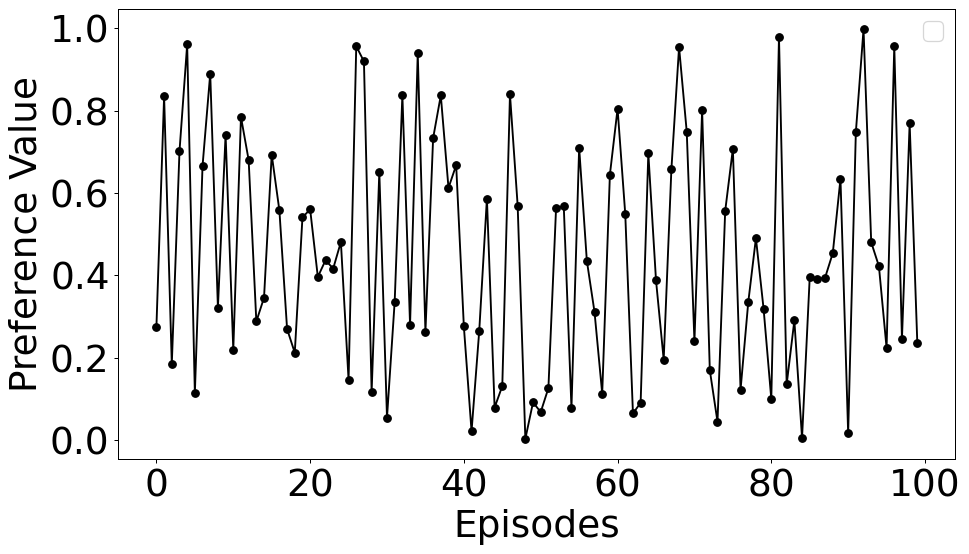

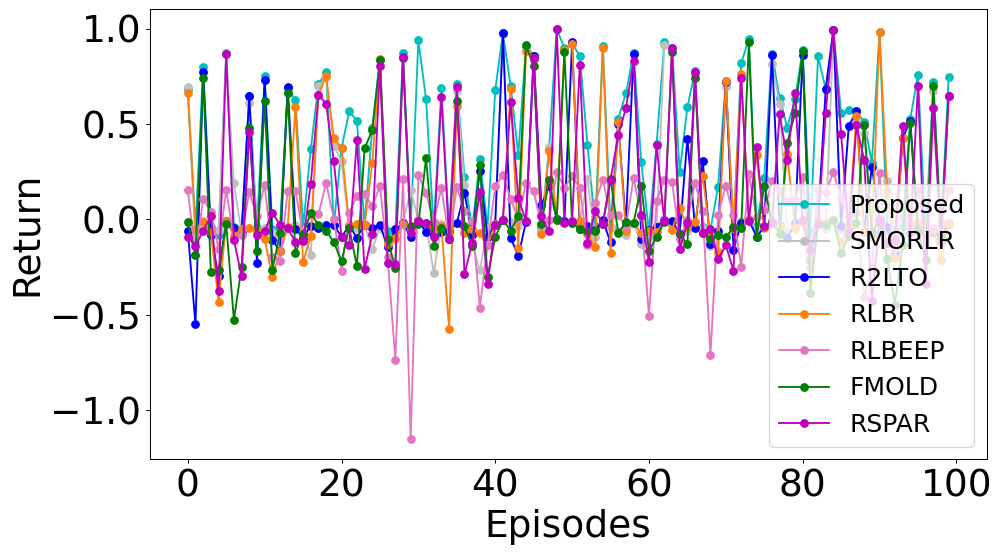

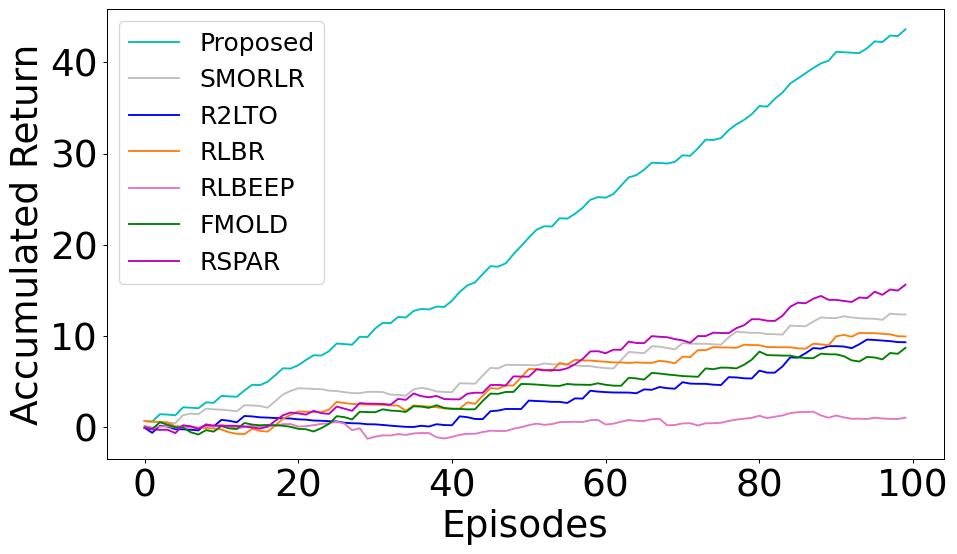

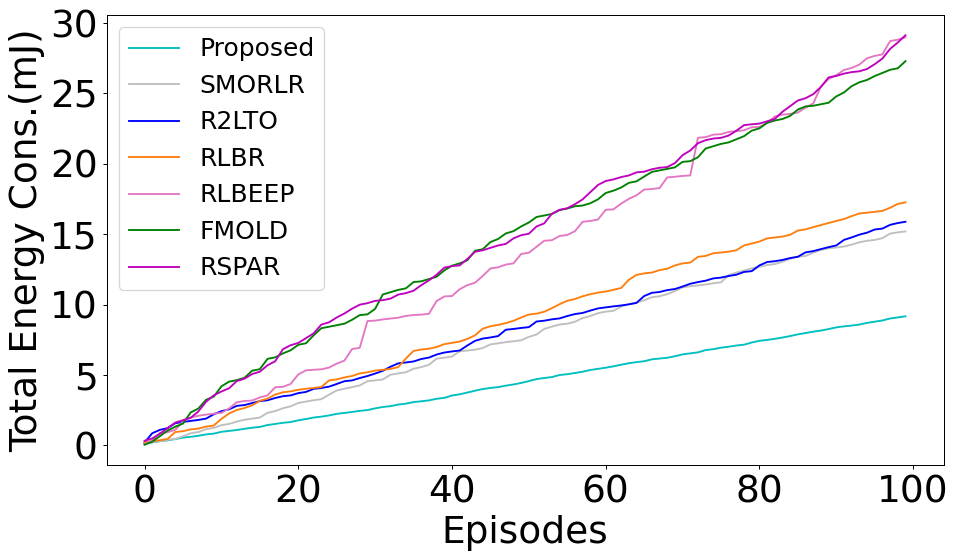

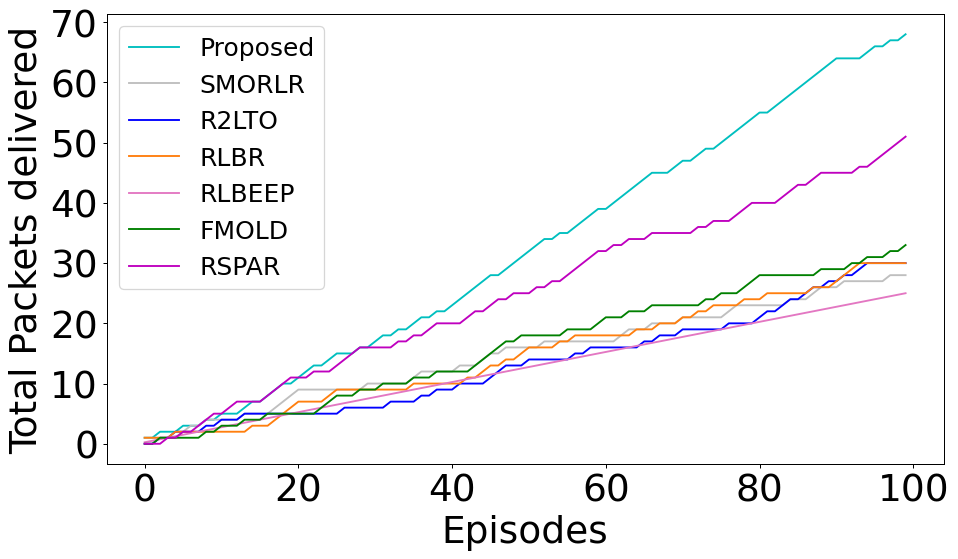

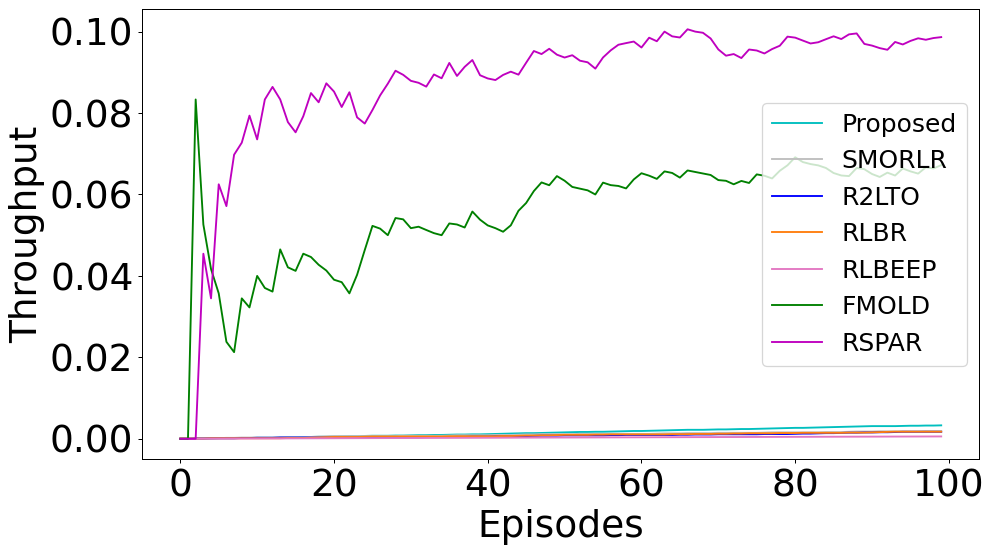

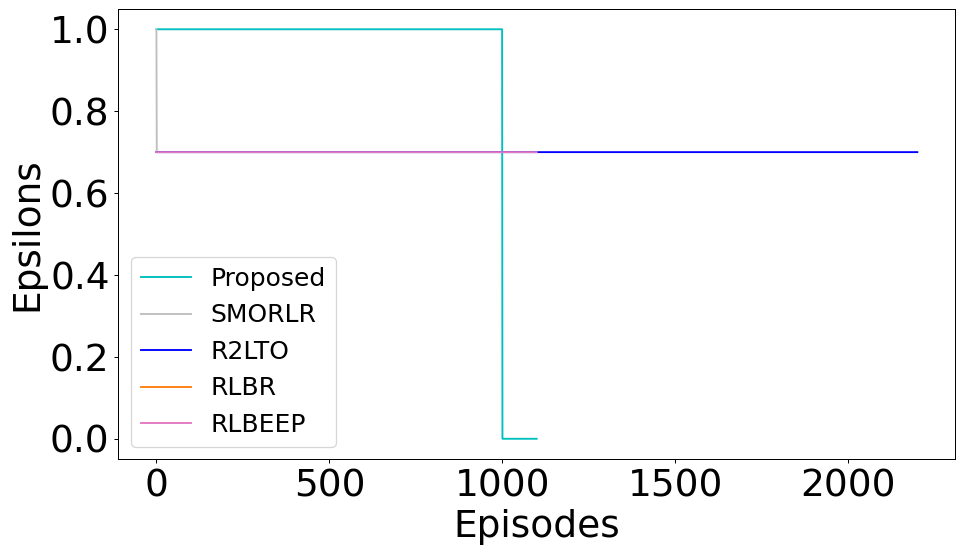

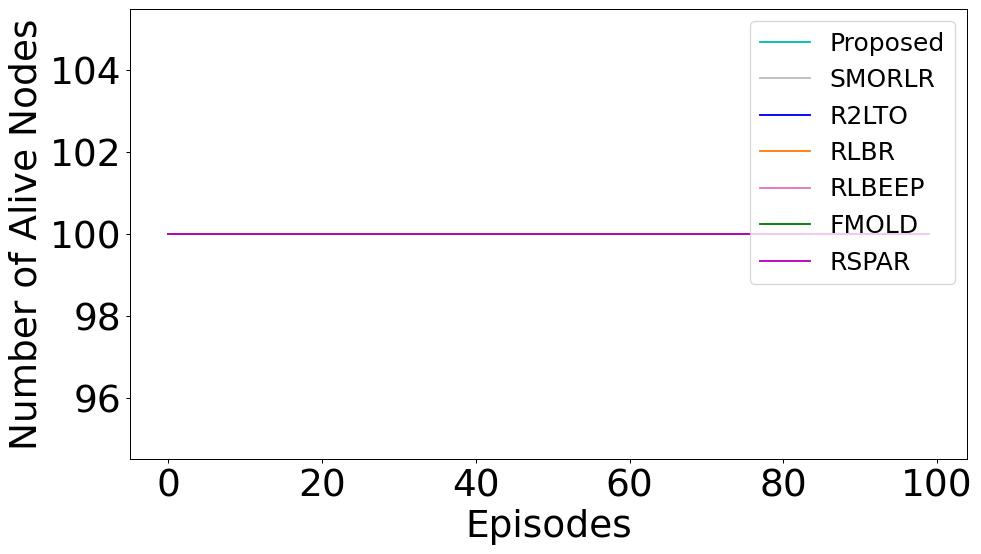

In [20]:
# Plot the results
plt.figure(figsize=(12, 6.5))
plt.plot(range(len(episode_preferences[:100])), episode_preferences[:100], color='k', marker='o')
plt.xlabel("Episodes", fontsize=30)
plt.ylabel("Preference Value", fontsize=30)
ax = plt.gca()
ax.set_facecolor('w')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
#plt.title("Comparing Epsilon")
plt.show()

plt.figure(figsize=(12, 6.5))
plt.plot(range(len(return_proposed)), return_proposed, color='c', marker='o', label='Proposed')
plt.plot(range(len(return_staticQ)), return_staticQ, color='0.75', marker='o', label='SMORLR')
plt.plot(range(len(return2)), return2, color='b', marker='o', label='R2LTO')
plt.plot(range(len(return3)), return3, color='tab:orange', marker='o', label='RLBR')
plt.plot(range(len(return4)), return4, color='tab:pink', marker='o', label='RLBEEP')
plt.plot(range(len(fuzzy_returns)), fuzzy_returns, color='g', marker='o', label='FMOLD')
plt.plot(range(len(RSPAR_returns)), RSPAR_returns, color='m', marker='o', label='RSPAR')
plt.xlabel("Episodes", fontsize=30)
plt.ylabel("Return", fontsize=30)
ax = plt.gca()
ax.set_facecolor('w')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 6.5))
plt.plot(range(len(acc_return_proposed)), acc_return_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_return_staticQ)), acc_return_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_return2)), acc_return2, color='b', label='R2LTO')
plt.plot(range(len(acc_return3)), acc_return3, color='tab:orange', label='RLBR')
plt.plot(range(len(acc_return4)), acc_return4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_tot_return)), fuzzy_tot_return, color='g', label='FMOLD')
plt.plot(range(len(RSPAR_tot_return)), RSPAR_tot_return, color='m', label='RSPAR')
plt.xlabel("Episodes", fontsize=30)
plt.ylabel("Accumulated Return", fontsize=30)
ax = plt.gca()
ax.set_facecolor('w')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
#plt.title("Comparing Epsilon")
plt.show()

x2 = range(len(acc_energy_proposed))
plt.figure(figsize=(12, 6.5))
# plt.plot(x, energy6, color='r', label='Proposed')
plt.plot(x2, acc_energy_proposed, color='c', label='Proposed')
plt.plot(range(len(acc_energy_staticQ)), acc_energy_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(acc_energy2)), acc_energy2, color='b', label='R2LTO')
plt.plot(range(len(acc_energy3)), acc_energy3, color='tab:orange', label='RLBR')
plt.plot(range(len(acc_energy4)), acc_energy4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_energy_consumption)), fuzzy_energy_consumption, color='g', label='FMOLD')
plt.plot(range(len(RSPAR_energy_consumption)), RSPAR_energy_consumption, color='m', label='RSPAR')
plt.xlabel("Episodes", fontsize=30)
plt.ylabel("Total Energy Cons.(mJ)", fontsize=30)
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.show()

x = range(len(packets_delivered_proposed))
plt.figure(figsize=(12, 6.5))
# plt.plot(x, delivery6, color='r', label='Proposed')
plt.plot(x, packets_delivered_proposed, color='c', label='Proposed')
plt.plot(range(len(packets_delivered_staticQ)), packets_delivered_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(packets_delivered2)), packets_delivered2, color='b', label='R2LTO')
plt.plot(range(len(packets_delivered3)), packets_delivered3, color='tab:orange', label='RLBR')
plt.plot(range(len(packets_delivered4)), packets_delivered4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_packets_delivered)), fuzzy_packets_delivered, color='g', label='FMOLD')
plt.plot(range(len(RSPAR_packets_delivered)), RSPAR_packets_delivered, color='m', label='RSPAR')
plt.xlabel("Episodes", fontsize=30)
plt.ylabel("Total Packets delivered", fontsize=30)
# plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
#plt.title("Comparing Epsilon")
plt.show()


# Plot the results
plt.figure(figsize=(12, 6.5))
plt.plot(range(len(throughput_proposed)), throughput_proposed, color='c', label='Proposed')
plt.plot(range(len(throughput_staticQ)), throughput_staticQ, color='0.75', label='SMORLR')
plt.plot(range(len(throughput2)), throughput2, color='b', label='R2LTO')
plt.plot(range(len(throughput3)), throughput3, color='tab:orange', label='RLBR')
plt.plot(range(len(throughput4)), throughput4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_throughput)), fuzzy_throughput, color='g', label='FMOLD')
plt.plot(range(len(RSPAR_throughput)), RSPAR_throughput, color='m', label='RSPAR')
plt.xlabel("Episodes", fontsize=30)
plt.ylabel("Throughput", fontsize=30)
ax = plt.gca()
ax.set_facecolor('w')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
#plt.title("Comparing Epsilon")
plt.show()


plt.figure(figsize=(12, 6.5))
plt.plot(range(len(epsilons_proposed)), epsilons_proposed, color='c', label='Proposed')
plt.plot(range(len(epsilons_staticQ)), epsilons_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(epsilons2)), epsilons2, color='b', label='R2LTO')
plt.plot(range(len(epsilons3)), epsilons3, color='tab:orange', label='RLBR')
plt.plot(range(len(epsilons4)), epsilons4, color='tab:pink', label='RLBEEP')
# plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
# plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Episodes", fontsize=30)
plt.ylabel("Epsilons", fontsize=30)
ax = plt.gca()
ax.set_facecolor('w')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
#plt.title("Comparing Epsilon")
plt.show()


# Plot networks' lifetime

x = range(len(alive_node_proposed))
plt.figure(figsize=(12, 6.5))
plt.plot(x, alive_node_proposed, color='c', label='Proposed')
plt.plot(range(len(alive_node_staticQ)), alive_node_staticQ, color = '0.75', label='SMORLR')
plt.plot(range(len(alive_node2)), alive_node2, color='b', label='R2LTO')
plt.plot(range(len(alive_node3)), alive_node3, color='tab:orange', label='RLBR')
plt.plot(range(len(alive_node4)), alive_node4, color='tab:pink', label='RLBEEP')
plt.plot(range(len(fuzzy_alive)), fuzzy_alive, color='g', label='FMOLD')
plt.plot(range(len(RSPAR_alive)), RSPAR_alive, color='m', label='RSPAR')
plt.xlabel("Episodes", fontsize=30)
plt.ylabel("Number of Alive Nodes", fontsize=30)
# plt.yscale('log')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
ax = plt.gca()
ax.set_facecolor('w')
plt.show()

In [ ]:
# put peference list in dict
d = {}
d['preferences'] = episode_preferences

# create dataframe
df = pd.DataFrame(d)

df.head()

df.to_csv('preferences.csv')